# All Model Errors

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

In [7]:
bool_wb = xr.open_dataset(data_dir / "RUNOFF/bool_water_balance_20pct.nc")
bool_wb = bool_wb.to_array().isel(variable=0).drop("variable")
bool_wb

<xarray.DataArray (station_id: 671)>
array([False,  True, False, False,  True,  True, False, False, False,
        True, False, False, False,  True,  True, False,  True, False,
        True,  True,  True, False,  True,  True, False,  True, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False, False,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True, False,  True,  True, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False,  True,  True,  True, False, False,  True, False,  True,
        True, False, False, False, False, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True, False,  True,  True,
        True, False, False,  True,  True,  True, False, False, False,
       False,  True,  True,  True,  True, False, False,  True,  True,
       False,  True, False,  True,  True, False, False,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True,  True, False,
       False, False,  True,  True, False,  True, False, False,  True,
        True, False, False,  True,  True,  True, False,  True,  True,
        True, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True,  True, False, False, False, False,  True,
       False, False,  True, False,  True,  True, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
        True, False,  True, False,  True, False,  True,  True,  True,
        True, False, False,  True, False,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False, False,  True, False, False, False, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False, False,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False, False, False,  True, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True, False, False,  True, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True, False, False, False,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  

# Read AWS Trained Models

In [8]:
lstm_ensemble_df_peti = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df_peti["time"] = pd.to_datetime(lstm_ensemble_df_peti["time"])
lstm_ensemble_peti = lstm_ensemble_df_peti.set_index(["station_id", "time"]).to_xarray()
lstm_preds_peti = lstm_ensemble_peti

In [9]:
# ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
# ealstm_preds = xr.open_dataset(data_dir / "runs/ensemble/data_ENS.csv")
ealstm_ensemble_df = pd.read_csv(data_dir / "runs/ensemble_EALSTM/data_ENS.csv").drop("Unnamed: 0", axis=1)
ealstm_ensemble_df["time"] = pd.to_datetime(ealstm_ensemble_df["time"])
ealstm_preds = ealstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()

ealstm_preds["station_id"] = [int(sid) for sid in ealstm_preds["station_id"]]

In [10]:
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble_pet/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble_pet_trainperiod/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df["time"] = pd.to_datetime(lstm_ensemble_df["time"])
lstm_ensemble = lstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()
lstm_preds = lstm_ensemble

In [11]:
lstm_preds_peti == lstm_preds

<xarray.Dataset>
Dimensions:     (station_id: 669, time: 4018)
Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    obs         (station_id, time) bool True True True True ... True True True
    sim         (station_id, time) bool False False False ... False False False

In [12]:
metric_df = pd.read_csv(data_dir / "runs/ensemble_pet/metric_df.csv", index_col=0)
metric_df.columns = [c.lower() for c in metric_df.columns]
metric_df.head()

,station_id,nse,kge,mse,fhv,fms,flv
0,10002,0.905340,0.867626,0.213530,-8.473469,15.031782,12.874872
1,10003,0.925870,0.880633,0.113025,-5.930443,2.789133,37.174278
2,1001,0.875410,0.916540,0.512555,0.733456,-23.276409,65.910174
3,101002,0.757151,0.649167,0.300624,-24.224581,-2.596738,70.965051
4,101005,0.827427,0.814456,0.205723,-16.600439,2.974179,44.405252


# FUSE Data

In [13]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

In [14]:
fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))

In [15]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["discharge_spec"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

# Test on only the water balancing stations?

In [94]:
ONLY_WATER_BALANCING = True



if ONLY_WATER_BALANCING:
    hold_out_fuse = fuse_data.sel(station_id=np.isin(fuse_data.station_id, bool_wb.where(~bool_wb, drop=True).station_id))
    fuse_data = fuse_data.sel(station_id=np.isin(fuse_data.station_id, bool_wb.where(bool_wb, drop=True).station_id))


# Match Stations / Times

In [95]:
if ONLY_WATER_BALANCING:
    hold_out_stations_lstm = np.isin(lstm_preds.station_id, hold_out_fuse.station_id)
    hold_out_stations_ealstm = np.isin(ealstm_preds.station_id, hold_out_fuse.station_id)
    
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)

In [96]:
if ONLY_WATER_BALANCING:
    hold_out_lstm_preds = lstm_preds.sel(station_id=hold_out_stations_lstm, time=fuse_data.time)
    hold_out_lstm_preds = ealstm_preds.sel(station_id=hold_out_stations_ealstm, time=fuse_data.time)

lstm_preds = lstm_preds.sel(station_id=all_stations_lstm, time=fuse_data.time)
ealstm_preds = ealstm_preds.sel(station_id=all_stations_ealstm, time=fuse_data.time)

# Errors

In [97]:
!git pull
from scripts.drafts.calculate_error_scores import calculate_errors, error_func

Already up to date.


In [98]:
ealstm_df = calculate_errors(ealstm_preds).set_index("station_id")
lstm_df = calculate_errors(lstm_preds).set_index("station_id")

# lstm_df.to_csv(data_dir / "RUNOFF/PET_LSTM_RESULTS.csv")

In [99]:
metric_df["rmse"] = np.sqrt(metric_df["mse"])
lstm_df["rmse"] = np.sqrt(lstm_df["mse"])
ealstm_df["rmse"] = np.sqrt(ealstm_df["mse"])

display(metric_df.set_index("station_id").sort_index().head())
display(lstm_df.sort_index().head())

,nse,kge,mse,fhv,fms,flv,rmse
station_id,,,,,,,
1001,0.875410,0.916540,0.512555,0.733456,-23.276409,65.910174,0.715930
2001,0.795517,0.734169,1.299555,-22.914962,-9.380016,15.606193,1.139980
2002,0.796522,0.704892,2.278604,-28.140312,-22.949306,61.070805,1.509504
3003,0.879771,0.849186,4.217607,-14.253567,-19.133229,45.264400,2.053681
4001,0.873894,0.879259,1.772178,-1.986958,-18.851530,44.173871,1.331232


,nse,kge,mse,bias,log_nse,inv_kge,rmse
station_id,,,,,,,
2001,0.773687,0.728138,1.438293,-13.445427,0.870523,0.728138,1.199288
4001,0.866291,0.860072,1.879023,-1.970809,0.797380,0.860072,1.370775
4003,0.826035,0.782560,2.114588,-7.473661,0.881892,0.782560,1.454162
6007,0.914473,0.849447,1.232530,-5.592752,0.843899,0.849447,1.110194
7003,0.843774,0.807583,0.441996,-5.575149,0.907332,0.807583,0.664828


In [100]:
# ealstm_nse = ealstm_df["nse"]
# lstm_nse = lstm_df["nse"]

# ealstm_nse['negative'] = ealstm_nse['nse'] < 0
# lstm_nse['negative'] = lstm_nse['nse'] < 0

# FUSE - Calculate from Sim

In [101]:
from scripts.drafts.calculate_error_scores import FuseErrors

In [102]:
fuse_errors_fp = data_dir / "RUNOFF/0_fuse_errors.pkl"
fuse_class_fp = data_dir / "RUNOFF/0_fuse_class.pkl"

# if not (fuse_errors_fp).exists() or not (fuse_class_fp).exists():
f_class = FuseErrors(fuse_data)
fuse_errors = f_class.fuse_errors
    
#     pickle.dump(f_class, fuse_class_fp.open("wb"))
#     pickle.dump(fuse_errors, fuse_errors_fp.open("wb"))
# else:
#     f_class = pickle.load(fuse_class_fp.open("rb"))
#     fuse_errors = pickle.load(fuse_errors_fp.open("rb"))

nse: 4it [00:04,  1.16s/it]
kge: 4it [00:05,  1.29s/it]
bias: 4it [00:02,  1.37it/s]
rmse: 4it [00:02,  1.34it/s]


In [103]:
fuse_bias = f_class.get_metric_df("bias")
fuse_nse_df = f_class.get_metric_df("nse")
fuse_kge_df = f_class.get_metric_df("kge")
fuse_kge_df.head()

,PRMS,Sacramento,TOPMODEL,VIC,Name
1001,NaN,NaN,NaN,NaN,Wick at Tarroul
2001,0.748769,0.742688,0.758969,0.698891,Helmsdale at Kilphedir
2002,NaN,NaN,NaN,NaN,Brora at Bruachrobie
3003,NaN,NaN,NaN,NaN,Oykel at Easter Turnaig
4001,0.828668,0.793088,0.733907,0.841072,Conon at Moy Bridge


In [104]:
model = "VIC"
vic_data = f_class.get_model_df(model)
vic_data.head()

,bias,kge,nse,rmse,Name
1001,NaN,NaN,NaN,NaN,Wick at Tarroul
2001,-2.899249,0.698891,0.685077,1.414721,Helmsdale at Kilphedir
2002,NaN,NaN,NaN,NaN,Brora at Bruachrobie
3003,NaN,NaN,NaN,NaN,Oykel at Easter Turnaig
4001,-3.086921,0.841072,0.818019,1.599187,Conon at Moy Bridge


### read published scores (best sim)

In [105]:
# !git pull

In [106]:
from scripts.drafts.calculate_error_scores import FUSEPublishedScores

In [107]:
fuse_dir = data_dir / "FUSE"
fpub = FUSEPublishedScores(fuse_dir)
pub_nse = fpub.read_nse_scores()
pub_best = fpub.read_best_scores()

In [108]:
# pub_nse

# Overall Model Performance Comparison
- Kolmogorov-Smirnov statistic on 2 samples
- This tests whether 2 samples are drawn from the same distribution
- Calculate the Wilcoxon signed-rank test
- tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.

In [109]:
from scipy.stats import wilcoxon, ks_2samp
from collections import defaultdict

models = ["TOPMODEL", "PRMS", "Sacramento", "VIC", "EALSTM"]
stations = lstm_df.index

comparison = fuse_nse_df.join(lstm_df["nse"]).rename({"nse": "LSTM"}, axis=1)
comparison = comparison.join(ealstm_df["nse"]).rename({"nse": "EALSTM"}, axis=1)

In [110]:
# f: FuseErrors
from typing import Callable, List


def _result_df(func: Callable, metric_df: pd.DataFrame, models: List[str], ref_model: str) -> pd.DataFrame:
    results = defaultdict(dict)
    for model in models:
        res_ = func(metric_df[model], metric_df[ref_model])
        results[model]["statistic"] = res_.statistic
        results[model]["pvalue"] = res_.pvalue
    
    return pd.DataFrame(results)


def create_joined_metric_df(metric: str):
    # build the dataframe of metrics (FUSE + LSTM + EALSTM)
    metric_df = f_class.get_metric_df(metric).join(lstm_df[metric]).rename({metric: "LSTM"}, axis=1)
    metric_df = metric_df.join(ealstm_df[metric]).rename({metric: "EALSTM"}, axis=1)
    metric_df = metric_df.dropna()
    return metric_df 


def run_test(test: str = "ks",  metric: str = "nse", ref_model: str = "LSTM"):
    assert test in ["ks", "wilcoxon"]
    lookup = {"ks": ks_2samp, "wilcoxon": wilcoxon}
    func = lookup[test]
    
    # build the dataframe of metrics (FUSE + LSTM + EALSTM)
    metric_df = create_joined_metric_df(metric=metric)
    
    other_model = "EALSTM" if ref_model == "LSTM" else "LSTM"
    models = ["TOPMODEL", "PRMS", "Sacramento", "VIC", other_model]
    # run the test
    df = _result_df(func, metric_df, models=models, ref_model=ref_model)
    return df

In [111]:
run_test("ks", "nse", "EALSTM")
run_test("ks", "nse", "LSTM")

,TOPMODEL,PRMS,Sacramento,VIC,EALSTM
statistic,5.758514e-01,5.232198e-01,3.900929e-01,4.736842e-01,0.065015
pvalue,7.641220e-50,9.777166e-41,2.589475e-22,3.834803e-33,0.502756


In [112]:
# display(run_test("ks", "nse", "LSTM"))
display(run_test("ks", "nse", "LSTM"))

,TOPMODEL,PRMS,Sacramento,VIC,EALSTM
statistic,5.758514e-01,5.232198e-01,3.900929e-01,4.736842e-01,0.065015
pvalue,7.641220e-50,9.777166e-41,2.589475e-22,3.834803e-33,0.502756


In [113]:
# Wilcoxon Test
data = create_joined_metric_df("nse")

wilcoxon_results = defaultdict(dict)
for model in models:
    res_ = wilcoxon(comparison.dropna()[model], comparison.dropna()["LSTM"])
    wilcoxon_results[model]["statistic"] = res_.statistic
    wilcoxon_results[model]["pvalue"] = res_.pvalue
    
pd.DataFrame(wilcoxon_results)

,TOPMODEL,PRMS,Sacramento,VIC,EALSTM
statistic,5.700000e+01,3.240000e+02,1.464000e+03,6.950000e+02,1.551700e+04
pvalue,1.789502e-54,2.111846e-53,6.004920e-49,6.251444e-52,2.324597e-10


#### significant testing bias

In [114]:
comparison = fuse_bias.join(lstm_df["bias"]).rename({"bias": "LSTM"}, axis=1)
comparison = comparison.join(ealstm_df["bias"]).rename({"bias": "EALSTM"}, axis=1)

(create_joined_metric_df("bias").dropna() == comparison.dropna()).mean()

PRMS          1.0
Sacramento    1.0
TOPMODEL      1.0
VIC           1.0
Name          1.0
LSTM          1.0
EALSTM        1.0
dtype: float64

In [115]:
# KS Test

ks_2samp_results = defaultdict(dict)
for model in models:
    res_ = ks_2samp(comparison.dropna()[model], comparison.dropna()["LSTM"])
    ks_2samp_results[model]["statistic"] = res_.statistic
    ks_2samp_results[model]["pvalue"] = res_.pvalue
    
display(pd.DataFrame(ks_2samp_results))

run_test("ks", "bias", "LSTM")

,TOPMODEL,PRMS,Sacramento,VIC,EALSTM
statistic,0.167183,2.910217e-01,0.080495,4.210526e-01,0.083591
pvalue,0.000233,1.844994e-12,0.246453,4.805996e-26,0.209283


,TOPMODEL,PRMS,Sacramento,VIC,EALSTM
statistic,0.167183,2.910217e-01,0.080495,4.210526e-01,0.083591
pvalue,0.000233,1.844994e-12,0.246453,4.805996e-26,0.209283


In [116]:
# Wilcoxon Test
wilcoxon_results = defaultdict(dict)
for model in models:
    res_ = wilcoxon(comparison.dropna()[model], comparison.dropna()["LSTM"])
    wilcoxon_results[model]["statistic"] = res_.statistic
    wilcoxon_results[model]["pvalue"] = res_.pvalue
    
display(pd.DataFrame(wilcoxon_results))
run_test("wilcoxon", "bias", "LSTM")

,TOPMODEL,PRMS,Sacramento,VIC,EALSTM
statistic,21675.000000,9.647000e+03,25871.000000,5.548000e+03,19583.000000
pvalue,0.007541,8.119070e-23,0.861987,1.259359e-34,0.000089


,TOPMODEL,PRMS,Sacramento,VIC,EALSTM
statistic,21675.000000,9.647000e+03,25871.000000,5.548000e+03,19583.000000
pvalue,0.007541,8.119070e-23,0.861987,1.259359e-34,0.000089


# NSE

In [117]:
ml_sids = np.isin(lstm_df.index, [sid for sid in fuse_nse_df.dropna().index])
concept_sids = np.isin(fuse_nse_df.index, [sid for sid in fuse_nse_df.dropna().index])

test_sids = [id_ for id_ in lstm_df[ml_sids].index]
# try:
#     lstm_nse = lstm_df["nse"].set_index("station_id")
#     ealstm_nse = ealstm_df["nse"].set_index("station_id")
# except KeyError:
#     print("Already set Index to SID!")

In [118]:
try:
    lstm_kwargs = {
        "clip": [-0.5, 1],
        "label": f"LSTM: {(lstm_data).median()}",
        "ls": "-",
        "linewidth": 3,
    }
    ealstm_kwargs = {
        "clip": [-0.5, 1],
        "label": f"EALSTM: {(ealstm_data).median()}",
        "ls": "-",
        "linewidth": 3,
    }

    def cdf_plot(data: pd.Series, ax, clip: List = [None, None], kwargs: Dict = {}):
        sns.kdeplot(
            lstm_data,
            cumulative=True,
            legend=False, ax=ax,
            **kwargs
        )


    # def plot_all_cdfs(metric: str, test_sids: List[int]):

    # lstm_data = lstm_df.loc[test_sids, 'nse']
    # ealstm_data = ealstm_df.loc[test_sids, 'nse']
    # concept_data = fuse_nse_df.loc[test_sids]

    # fig, ax = plt.subplots(figsize=(12, 8))

except NameError:
    print("LSTM Data not yet defined")

LSTM Data not yet defined


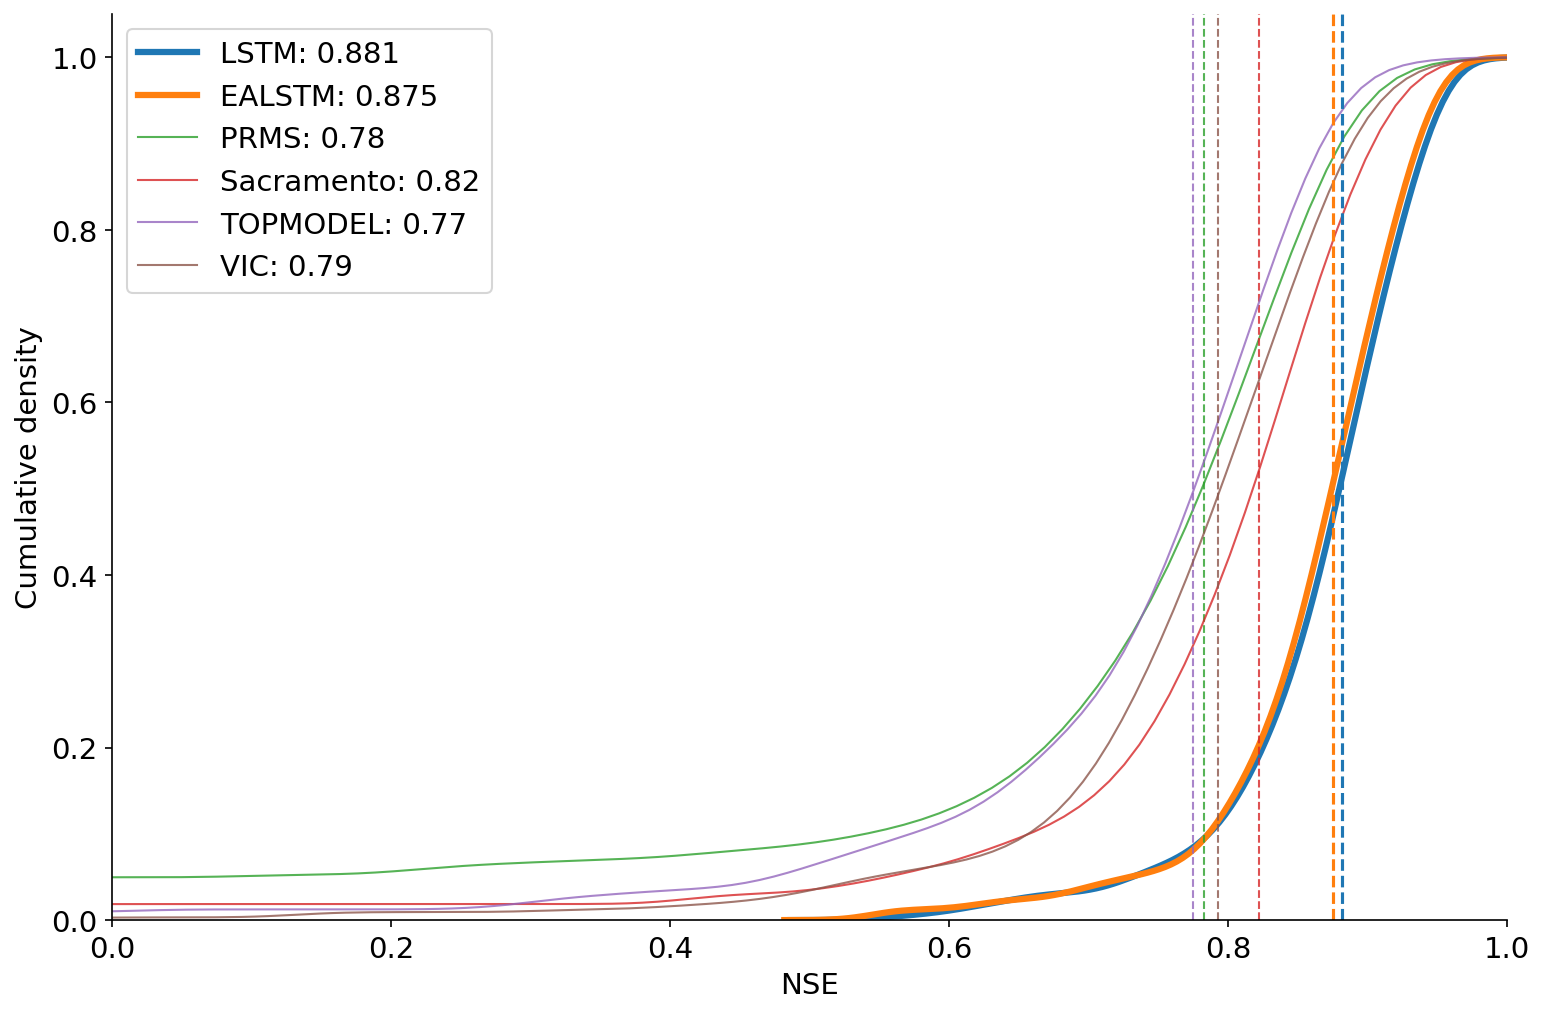

In [119]:
colors = sns.color_palette()

lstm_data = lstm_df.loc[ml_sids, 'nse']
ealstm_data = ealstm_df.loc[ml_sids, 'nse']
concept_data = fuse_nse_df.loc[concept_sids]

n_negative_nse = False

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    lstm_data,
    cumulative=True,
    legend=False, ax=ax,
    clip=[-0.5, 1],
    label=f"LSTM: {(lstm_data < 0).sum()} Station NSEs < 0" if n_negative_nse else f"LSTM: {lstm_data.median():.3f}",
    **{"ls": "-"},
    linewidth=3,
)

sns.kdeplot(
    ealstm_data,
    cumulative=True,
    legend=False, ax=ax,
    clip=[-0.5, 1],
    label=f"EALSTM: {(ealstm_data < 0).sum()} Station NSEs < 0" if n_negative_nse else f"EALSTM: {ealstm_data.median():.3f}",
    linewidth=3,
)

for conceptual_ix, model in enumerate([c for c in concept_data.columns if (not "Name" in c) and (not "station" in c)]):
    sns.kdeplot(
        concept_data[model].dropna(),
        cumulative=True,
        legend=False, ax=ax,
        clip=[-0.5, 1],
        label=f"{model}: {(concept_data[model] < 0).sum()} Station NSEs < 0" if n_negative_nse else f"{model}: {concept_data[model].median():.2f}",
        color=colors[conceptual_ix+2], alpha=0.8, linewidth=1
    )
    plt.legend()
    ax.axvline(concept_data[model].dropna().median(), ls="--", color=colors[conceptual_ix+2], alpha=0.8, linewidth=1)  # color=colors[conceptual_ix+1]


ax.axvline(lstm_data.median(), ls="--", color=colors[0])
ax.axvline(ealstm_data.median(), ls="--", color=colors[1])

ax.set_xlim([-0, 1])
ax.set_xlabel("NSE")
ax.set_ylabel("Cumulative density")
title = f"Cumuluative Density Function of Station NSE Scores"
# ax.set_title(title)
ax.set_title("")
sns.despine()

In [120]:
print(f"LSTM NSE: {lstm_df['nse'].median():.2f}")
print(f"EALSTM NSE: {ealstm_df['nse'].median():.2f}")

for model in [c for c in fuse_nse_df.columns if (not "Name" in c) and (not "station" in c)]:
    print(f"{model} NSE: {fuse_nse_df[model].dropna().median():.2f}")

LSTM NSE: 0.88
EALSTM NSE: 0.88
PRMS NSE: 0.78
Sacramento NSE: 0.82
TOPMODEL NSE: 0.77
VIC NSE: 0.79


In [121]:
print(lstm_df.shape)
print(fuse_nse_df.dropna().shape)

(323, 7)
(323, 5)


# Bias

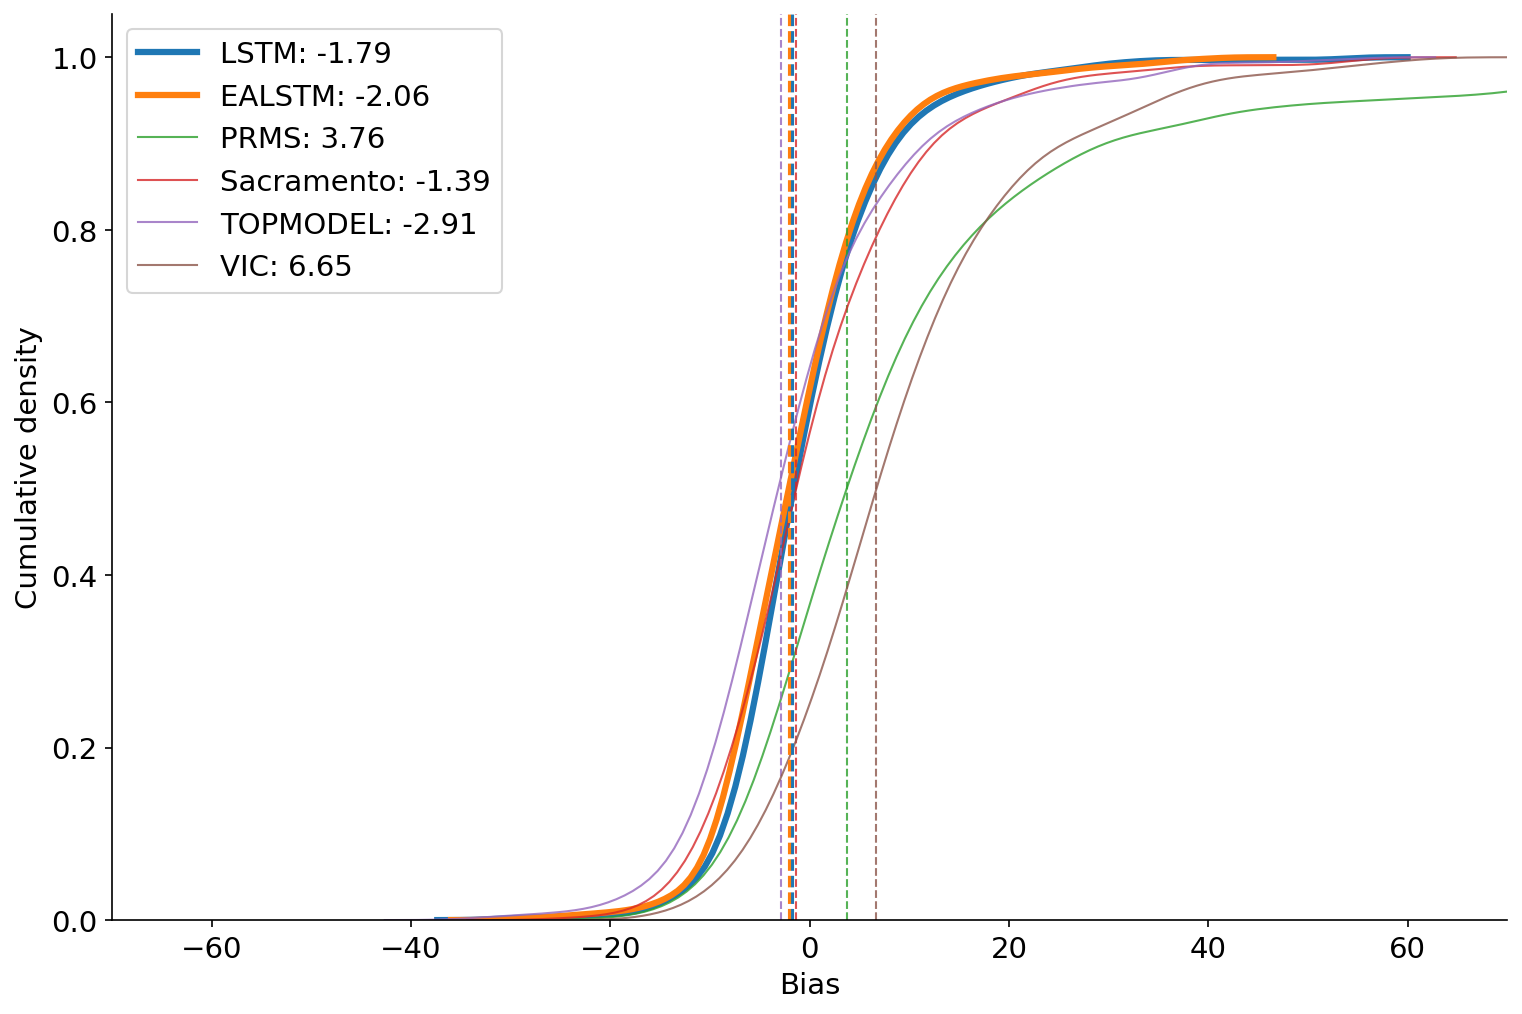

In [122]:
colors = sns.color_palette()

lstm_data = lstm_df.loc[ml_sids, 'bias']
ealstm_data = ealstm_df.loc[ml_sids, 'bias']
concept_data = fuse_bias.loc[concept_sids]

clip = [-70, 70]
xlim = [-70, 70]

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    lstm_data,
    cumulative=True,
    legend=False, ax=ax,
    clip=clip,
    label=f"LSTM: {lstm_data.median():.2f}",
    **{"ls": "-"},
    linewidth=3,
)

sns.kdeplot(
    ealstm_data,
    cumulative=True,
    legend=False, ax=ax,
    clip=clip,
    label=f"EALSTM: {ealstm_data.median():.2f}",
    linewidth=3,
)

for conceptual_ix, model in enumerate([c for c in concept_data.columns if (not "Name" in c) and (not "station" in c)]):
    sns.kdeplot(
        concept_data[model].dropna(),
        cumulative=True,
        legend=False, ax=ax,
        clip=clip,
        label=f"{model}: {concept_data[model].median():.2f}",
        linewidth=1, color=colors[conceptual_ix+2], alpha=0.8
    )
    plt.legend()
    ax.axvline(concept_data[model].dropna().median(), ls="--", color=colors[conceptual_ix+2], alpha=0.8, linewidth=1)  # color=colors[conceptual_ix+1]


ax.axvline(lstm_data.median(), ls="--", color=colors[0])
ax.axvline(ealstm_data.median(), ls="--", color=colors[1])

ax.set_xlim(xlim)
ax.set_xlabel("Bias")
ax.set_ylabel("Cumulative density")
title = f"Cumuluative Density Function of Station Bias Scores"
ax.set_title(title)
ax.set_title("")
sns.despine()

In [123]:
ml_sids; concept_sids;

In [124]:
print(f"LSTM Bias: {lstm_df.loc[ml_sids, 'bias'].median():.2f}")
print(f"EALSTM Bias: {ealstm_df.loc[ml_sids, 'bias'].median():.2f}")

for model in [c for c in fuse_nse_df.columns if (not "Name" in c) and (not "station" in c)]:
    print(f"{model} Bias: {fuse_bias.loc[concept_sids, model].dropna().median():.2f}")

LSTM Bias: -1.79
EALSTM Bias: -2.06
PRMS Bias: 3.76
Sacramento Bias: -1.39
TOPMODEL Bias: -2.91
VIC Bias: 6.65


In [125]:
print(f"LSTM Bias: {lstm_df.loc[ml_sids, 'bias'].mean():.2f}")
print(f"EALSTM Bias: {ealstm_df.loc[ml_sids, 'bias'].mean():.2f}")

for model in [c for c in fuse_nse_df.columns if (not "Name" in c) and (not "station" in c)]:
    print(f"{model} Bias: {fuse_bias.loc[concept_sids, model].dropna().mean():.2f}")

LSTM Bias: -0.60
EALSTM Bias: -1.27
PRMS Bias: 9.42
Sacramento Bias: 0.24
TOPMODEL Bias: -1.45
VIC Bias: 8.69


# KGE

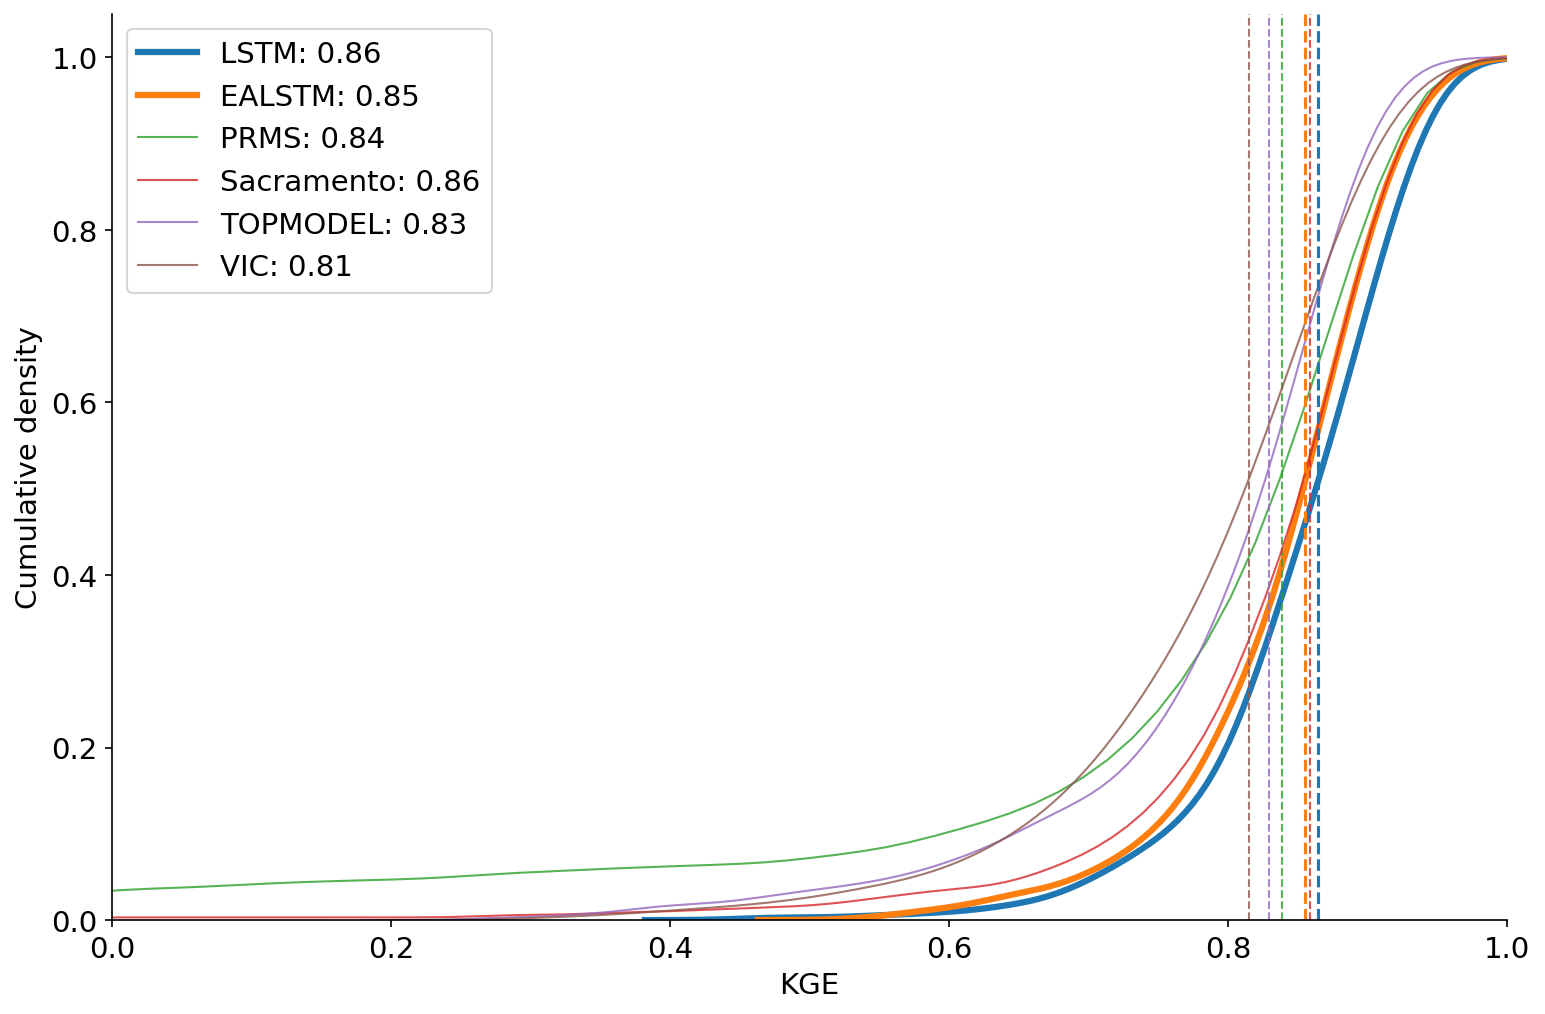

In [126]:
colors = sns.color_palette()

lstm_data = lstm_df.loc[ml_sids, 'kge']
ealstm_data = ealstm_df.loc[ml_sids, 'kge']
concept_data = fuse_kge_df.loc[concept_sids]

clip = None
xlim = [0, 1]

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    lstm_data,
    cumulative=True,
    legend=False, ax=ax,
    clip=clip,
    label=f"LSTM: {lstm_data.median():.2f}",
    **{"ls": "-"},
    linewidth=3,
)

sns.kdeplot(
    ealstm_data,
    cumulative=True,
    legend=False, ax=ax,
    clip=clip,
    label=f"EALSTM: {ealstm_data.median():.2f}",
    linewidth=3,
)

for conceptual_ix, model in enumerate([c for c in concept_data.columns if (not "Name" in c) and (not "station" in c)]):
    sns.kdeplot(
        concept_data[model].dropna(),
        cumulative=True,
        legend=False, ax=ax,
        clip=clip,
        label=f"{model}: {concept_data[model].median():.2f}",
        linewidth=1, color=colors[conceptual_ix+2], alpha=0.8
    )
    plt.legend()
    ax.axvline(concept_data[model].dropna().median(), ls="--", color=colors[conceptual_ix+2], alpha=0.8, linewidth=1)  # color=colors[conceptual_ix+1]


ax.axvline(lstm_data.median(), ls="--", color=colors[0])
ax.axvline(ealstm_data.median(), ls="--", color=colors[1])

ax.set_xlim(xlim)
ax.set_xlabel("KGE")
ax.set_ylabel("Cumulative density")
title = f"Cumuluative Density Function of Station KGE Scores"
ax.set_title(title)
ax.set_title("")
sns.despine()

In [127]:
print(f"LSTM KGE: {lstm_df['kge'].median():.3f}")
print(f"EALSTM KGE: {ealstm_df['kge'].median():.3f}")

for model in [c for c in fuse_nse_df.columns if (not "Name" in c) and (not "station" in c)]:
    print(f"{model} KGE: {fuse_kge_df[model].dropna().median():.3f}")

LSTM KGE: 0.865
EALSTM KGE: 0.855
PRMS KGE: 0.839
Sacramento KGE: 0.859
TOPMODEL KGE: 0.829
VIC KGE: 0.815


In [128]:
# Significance tests

# Tables

In [129]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [130]:
process_errors = pd.read_csv(data_dir / "RUNOFF/jules_classic.csv")

classic = process_errors.loc[process_errors["Model"] == "Classic", :].drop('Model', axis=1)
classic = classic.rename(columns={"ID": "Station ID"}).set_index("Station ID")
classic.columns = [["CLASSIC" for _ in range(len(classic.columns))], classic.columns]

jules = process_errors.loc[process_errors["Model"] == "Jules", :].drop('Model', axis=1)
jules = jules.rename(columns={"ID": "Station ID"}).set_index("Station ID").drop("Name", axis=1)
jules.columns = [["JULES" for _ in range(len(jules.columns))], jules.columns]

process_errors = pd.concat([classic, jules], axis=1)
process_errors.to_pickle(data_dir / "RUNOFF/process_models.pkl")
process_errors

CLASSIC             JULES      
                                  Name   NSE  Bias   NSE  Bias
Station ID                                                    
12002                     Dee at Park   0.55  -3.4  0.51 -20.0
15006                Tay at Ballathie   0.46  -7.7  0.64 -15.0
27009                 Ouse at Skelton   0.80   3.1  0.69 -18.0
27034           Ure at Kilgram Bridge   0.78   2.8  0.75 -19.0
27041         Derwent at Buttercrambe   0.65  -5.3  0.49 -27.0
39001              Thames at Kingston   0.81  -5.9  0.82 -11.0
39081                 Ock at Abingdon   0.80 -13.6 -0.21 -63.0
43021              Avon at Knapp Mill   0.60 -17.6 -0.07 -20.0
47001             Tamar at Gunnislake   0.82   0.6  0.63 -18.0
54001               Severn at Bewdley   0.66   4.6  0.61  -7.0
54057            Severn at Haw Bridge   0.78   2.1  0.72 -14.0
71001            Ribble at Samlesbury   0.73   0.4  0.74 -18.0
84013               Clyde at Daldowie   0.80  -2.5  0.82 -24.0

In [131]:
# NSE
nse = fuse_nse_df.join(
    ealstm_df["nse"].rename("EALSTM")
)
nse = nse.join(
    lstm_df["nse"].rename("LSTM")
)

# BIAS
bias = fuse_bias.join(
    ealstm_df["bias"].rename("EALSTM")
)
bias = bias.join(
    lstm_df["bias"].rename("LSTM")
)
bias['Name'] = nse["Name"]
bias = bias[["Name"] + [c for c in bias.columns if c != "Name"]]

In [132]:
nse_13 = nse.loc[catchment_ids]
nse_13.index.name = "Station ID"
bias_13 = bias.loc[catchment_ids]
bias_13.index.name = "Station ID"

In [133]:
columns = ["Name",
 "LSTM",
 "EALSTM",
 "CLASSIC",
 "JULES",
"PRMS",
"Sacramento",
"TOPMODEL",
"VIC"]

all_bias = bias_13.join(process_errors.drop(["NSE", "Name"], axis=1, level=1).droplevel(axis=1, level=1))
all_bias = all_bias[columns]
all_bias.head()

,Name,LSTM,EALSTM,CLASSIC,JULES,PRMS,Sacramento,TOPMODEL,VIC
Station ID,,,,,,,,,
12002,Dee at Park,-3.715792,-4.746423,-3.4,-20.0,-5.891325,-8.656066,-6.717094,3.777818
15006,Tay at Ballathie,-0.857450,-5.324174,-7.7,-15.0,-7.772399,-9.111110,-8.738080,6.701808
27009,Ouse at Skelton,1.203581,-1.288448,3.1,-18.0,3.822976,3.123150,4.965586,9.061319
27034,Ure at Kilgram Bridge,-4.349062,-7.882600,2.8,-19.0,-1.235082,-9.462886,-6.786685,-4.142822
27041,Derwent at Buttercrambe,-5.407978,-6.984651,-5.3,-27.0,9.558003,9.999352,0.378740,18.773763


In [134]:
all_nse = nse_13.join(process_errors.drop(["Bias", "Name"], axis=1, level=1).droplevel(axis=1, level=1))
all_nse = all_nse[columns]

all_nse.head()
all_nse

,Name,LSTM,EALSTM,CLASSIC,JULES,PRMS,Sacramento,TOPMODEL,VIC
Station ID,,,,,,,,,
12002,Dee at Park,0.884020,0.875156,0.55,0.51,0.678902,0.705813,0.650839,0.712115
15006,Tay at Ballathie,0.941552,0.933297,0.46,0.64,0.857088,0.878198,0.794052,0.884469
27009,Ouse at Skelton,0.936267,0.908954,0.80,0.69,0.884996,0.907853,0.862102,0.892699
27034,Ure at Kilgram Bridge,0.872425,0.874830,0.78,0.75,0.846070,0.852412,0.841413,0.844337
27041,Derwent at Buttercrambe,0.922852,0.791536,0.65,0.49,0.820129,0.869873,0.774834,0.780194
39001,Thames at Kingston,0.952040,0.938562,0.81,0.82,0.686639,0.882496,0.752798,0.782795
39081,Ock at Abingdon,NaN,NaN,0.80,-0.21,NaN,NaN,NaN,NaN
43021,Avon at Knapp Mill,0.906855,0.924441,0.60,-0.07,0.837635,0.893386,0.536147,0.907952
47001,Tamar at Gunnislake,0.932461,0.938111,0.82,0.63,0.875593,0.890517,0.864220,0.889927


In [135]:
print(all_nse.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrr}
\toprule
{} &                     Name &  LSTM &  EALSTM &  CLASSIC &  JULES &  PRMS &  Sacramento &  TOPMODEL &  VIC \\
Station ID &                          &       &         &          &        &       &             &           &      \\
\midrule
12002      &              Dee at Park &  0.88 &    0.88 &     0.55 &   0.51 &  0.68 &        0.71 &      0.65 & 0.71 \\
15006      &         Tay at Ballathie &  0.94 &    0.93 &     0.46 &   0.64 &  0.86 &        0.88 &      0.79 & 0.88 \\
27009      &          Ouse at Skelton &  0.94 &    0.91 &     0.80 &   0.69 &  0.88 &        0.91 &      0.86 & 0.89 \\
27034      &    Ure at Kilgram Bridge &  0.87 &    0.87 &     0.78 &   0.75 &  0.85 &        0.85 &      0.84 & 0.84 \\
27041      &  Derwent at Buttercrambe &  0.92 &    0.79 &     0.65 &   0.49 &  0.82 &        0.87 &      0.77 & 0.78 \\
39001      &       Thames at Kingston &  0.95 &    0.94 &     0.81 &   0.82 &  0.69 &        0.88 &      0.75 & 0.78 \\
39

In [136]:
print(all_bias.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrr}
\toprule
{} &                     Name &  LSTM &  EALSTM &  CLASSIC &  JULES &  PRMS &  Sacramento &  TOPMODEL &   VIC \\
Station ID &                          &       &         &          &        &       &             &           &       \\
\midrule
12002      &              Dee at Park & -3.72 &   -4.75 &    -3.40 & -20.00 & -5.89 &       -8.66 &     -6.72 &  3.78 \\
15006      &         Tay at Ballathie & -0.86 &   -5.32 &    -7.70 & -15.00 & -7.77 &       -9.11 &     -8.74 &  6.70 \\
27009      &          Ouse at Skelton &  1.20 &   -1.29 &     3.10 & -18.00 &  3.82 &        3.12 &      4.97 &  9.06 \\
27034      &    Ure at Kilgram Bridge & -4.35 &   -7.88 &     2.80 & -19.00 & -1.24 &       -9.46 &     -6.79 & -4.14 \\
27041      &  Derwent at Buttercrambe & -5.41 &   -6.98 &    -5.30 & -27.00 &  9.56 &       10.00 &      0.38 & 18.77 \\
39001      &       Thames at Kingston &  4.00 &    2.84 &    -5.90 & -11.00 & 43.07 &       11.31 &      0.20 & 16.

In [137]:
all_nse.to_csv(data_dir / "RUNOFF/all_nse.csv")
all_bias.to_csv(data_dir / "RUNOFF/all_bias.csv")

# Spatial Plots

In [138]:
vic_errors = f_class.get_model_df("VIC")
prms_errors = f_class.get_model_df("PRMS")
top_errors = f_class.get_model_df("TOPMODEL")
sac_errors = f_class.get_model_df("Sacramento")

vic_errors.head()
# fuse_errors.drop("Name", axis=1, level=1)

,bias,kge,nse,rmse,Name
1001,NaN,NaN,NaN,NaN,Wick at Tarroul
2001,-2.899249,0.698891,0.685077,1.414721,Helmsdale at Kilphedir
2002,NaN,NaN,NaN,NaN,Brora at Bruachrobie
3003,NaN,NaN,NaN,NaN,Oykel at Easter Turnaig
4001,-3.086921,0.841072,0.818019,1.599187,Conon at Moy Bridge


# Create Geospatial Map
- http://darribas.org/gds15/content/labs/lab_03.html

In [139]:
import geopandas as gpd

shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}  # 4277  27700

In [140]:
def create_spatial_dataframe(error_df: pd.DataFrame, geo_df: gpd.GeoDataFrame, polygon: bool = False) -> gpd.GeoDataFrame:
    assert error_df.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
    error_gdf = gpd.GeoDataFrame(
        geo_df.set_index('ID_STRING').join(error_df)
    )
    if not polygon:
        static_df = static.to_dataframe()
        d = static_df[["gauge_lat", "gauge_lon"]]

        points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
        points.name = "geometry"
        error_gdf = error_gdf.drop("geometry", axis=1).join(points)
        error_gdf.crs = {'init' :'epsg:4326'}
    else:
        error_gdf.crs = {'init' :'epsg:27700'}
        
    return error_gdf
    
    
lstm_gdf = create_spatial_dataframe(lstm_df, geo_df)
ealstm_gdf = create_spatial_dataframe(ealstm_df, geo_df)
vic_gdf  = create_spatial_dataframe(vic_errors, geo_df)
prms_gdf  = create_spatial_dataframe(prms_errors, geo_df)
top_gdf  = create_spatial_dataframe(top_errors, geo_df)
sac_gdf  = create_spatial_dataframe(sac_errors, geo_df)

In [141]:
# lstm_gdf.to_file(data_dir / "RUNOFF/shp_files/lstm.shp")
# ealstm_gdf.to_file(data_dir / "RUNOFF/shp_files/ealstm.shp")
# vic_gdf.to_file(data_dir / "RUNOFF/shp_files/vic.shp")
# prms_gdf.to_file(data_dir / "RUNOFF/shp_files/prms.shp")
# top_gdf.to_file(data_dir / "RUNOFF/shp_files/top.shp")
# sac_gdf.to_file(data_dir / "RUNOFF/shp_files/sac.shp")

## Get UK Boundaries

Get the COUNTY SHAPE data [here:](https://opendata.arcgis.com/datasets/1919db8ffcc5445ea4ba5b8a10acfccd_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D)
```
!wget https://opendata.arcgis.com/datasets/1919db8ffcc5445ea4ba5b8a10acfccd_0.zip
!unzip 1919db8ffcc5445ea4ba5b8a10acfccd_0.zip
!mkdir Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC
!mv Counties* Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC
```

Get all of these shapefiles and merge into one big polygon
```python
uk = gpd.read_file(data_dir / "RUNOFF/Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC/Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC.shp")
uk.plot()

from shapely.ops import unary_union  # cascaded_union, 
uk_bound = unary_union([p for p in uk.geometry])
uk_bound = gpd.GeoSeries(uk_bound)
```

[Link to CRS Discussion](https://communityhub.esriuk.com/geoxchange/2012/3/26/coordinate-systems-and-projections-for-beginners.html#:~:text=If%20you%20work%20with%20UK,that%20you%20should%20know%20about.&text=Web%20Mercator%20is%20a%20PCS,36%20used%20for%20British%20maps)


![title](https://static1.squarespace.com/static/55bb8935e4b046642e9d3fa7/55bb8e8ee4b03fcc125a74c0/55bb8e91e4b03fcc125a7a67/1331725592717/1000w/coordsys_diagram.png)


In [142]:
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

In [143]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
markersize = 10
# "scheme": "quantiles" if quantiles else None
opts = {
    "rmse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis', "markersize": markersize},   # rmse   
    "rmse_norm": {"vmin": 0, "vmax": 0.5, 'cmap': 'viridis', "markersize": markersize},   # rmse   
    "nse": {"vmin": 0.7, "vmax": 1, 'cmap': 'viridis_r', "markersize": markersize},    # nse  8
    "kge": {"vmin": 0.7, "vmax": 1, 'cmap': 'plasma_r', "markersize": markersize},    # kge   
    "bias": {"vmin": -20, "vmax": 20, 'cmap': 'RdBu', "markersize": markersize}    # bias  
}

from typing import List 

def plot_geospatial_data(model_data, model: str, metrics: List[str] = ["nse", "bias", "kge"]):
    
    fig, axs = plt.subplots(1, 3, figsize=(5*3, 8))
    
    for ix, metric in enumerate(metrics):
        ax = axs[ix]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        # plot the chloropleth
        model_data.to_crs(epsg=4326).plot(metric, ax=ax, legend=True, cax=cax, **opts[metric]);
        
        # plot the surrounding lines
        uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
        
        ax.set_xlim([-8.2, 2.1])
        ax.set_ylim([50, 59.5])
        ax.axis('off');

        ax.set_title(metric.upper())

#     fig.tight_layout(rect=[0, 0.03, 1, 0.965]);
#     fig.suptitle(f"{model} Model Error", size=14);

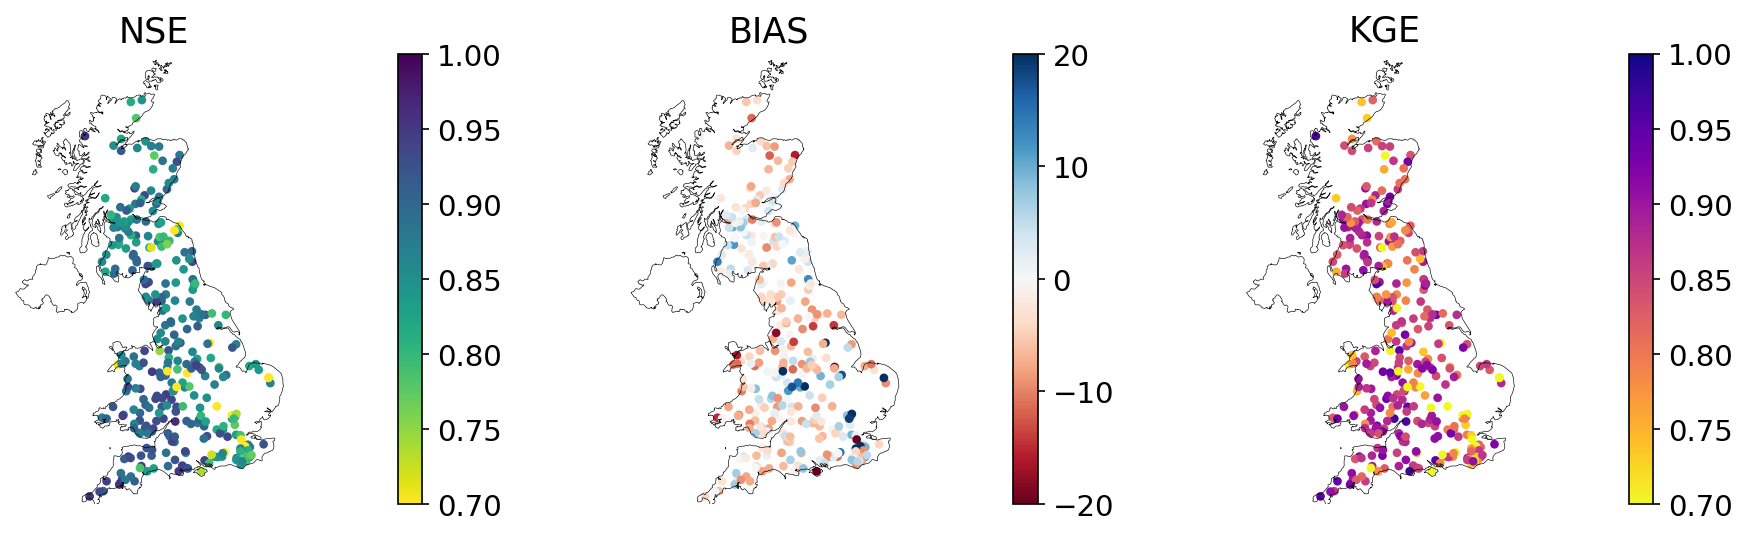

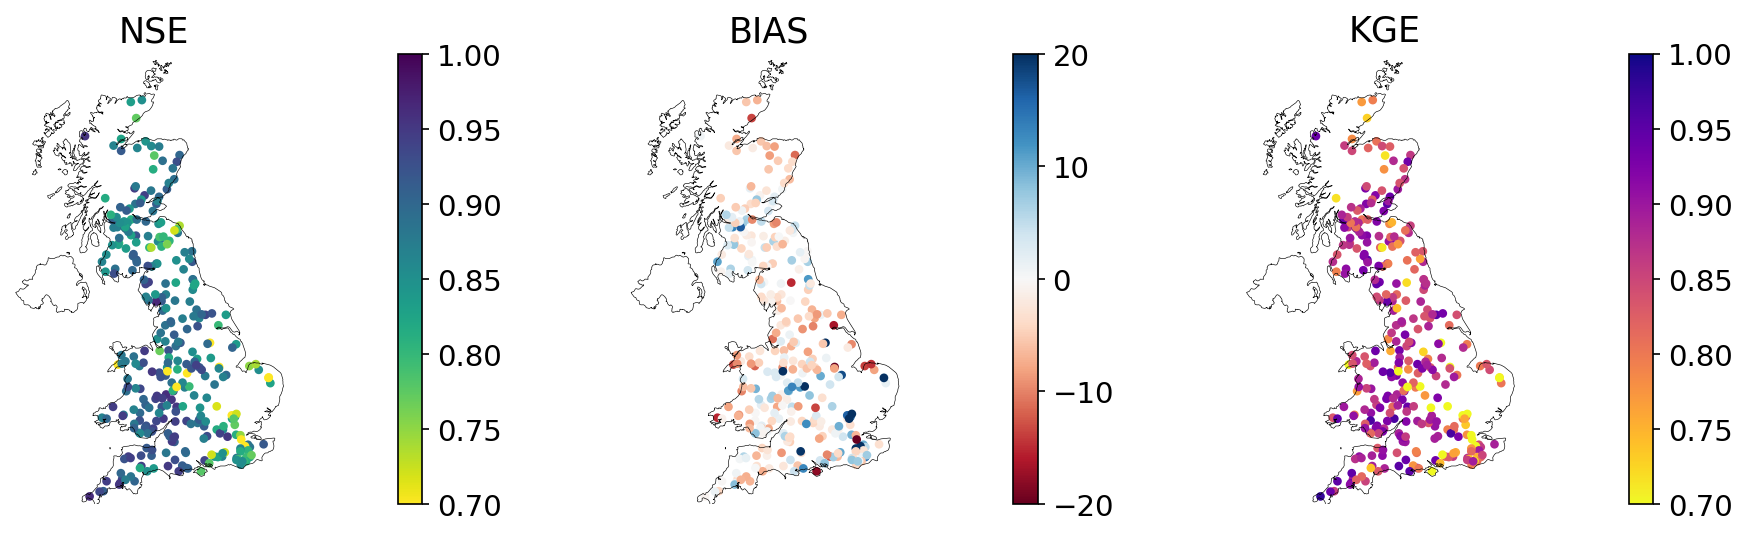

In [144]:
plot_geospatial_data(ealstm_gdf, model="EALSTM")
plot_geospatial_data(lstm_gdf, model="LSTM")

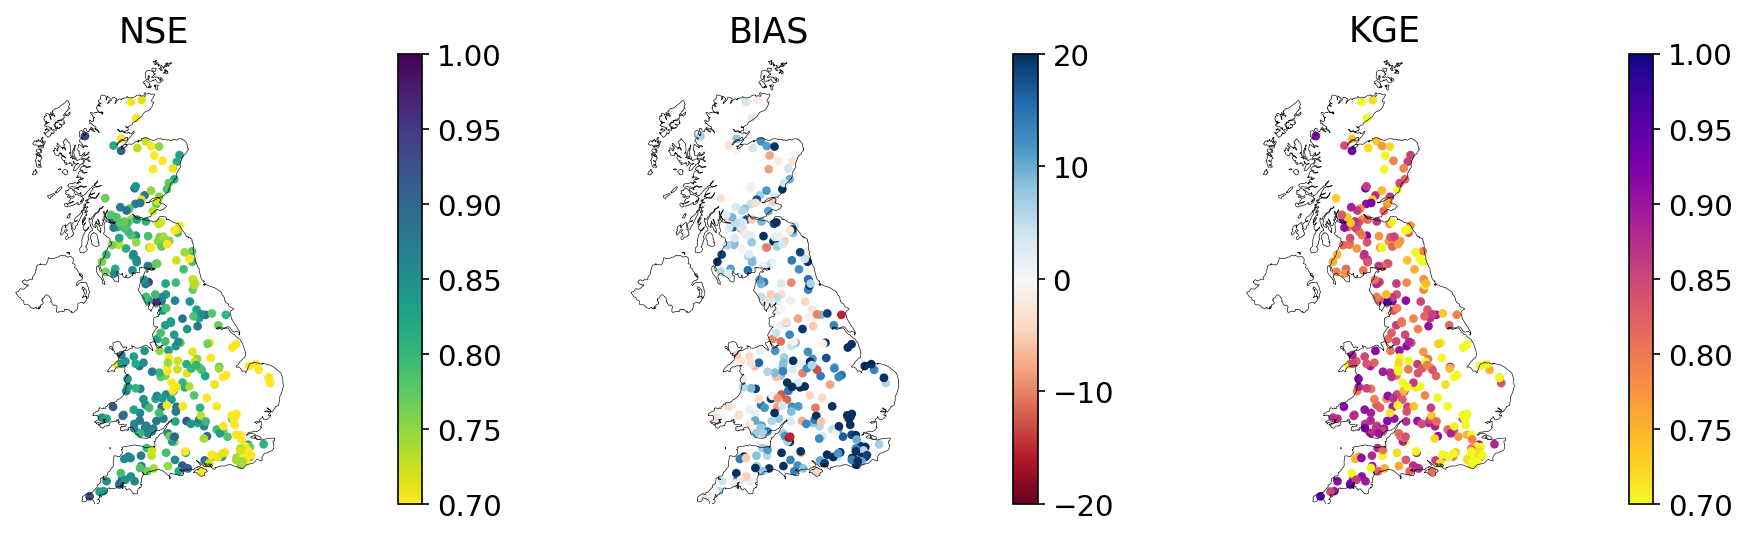

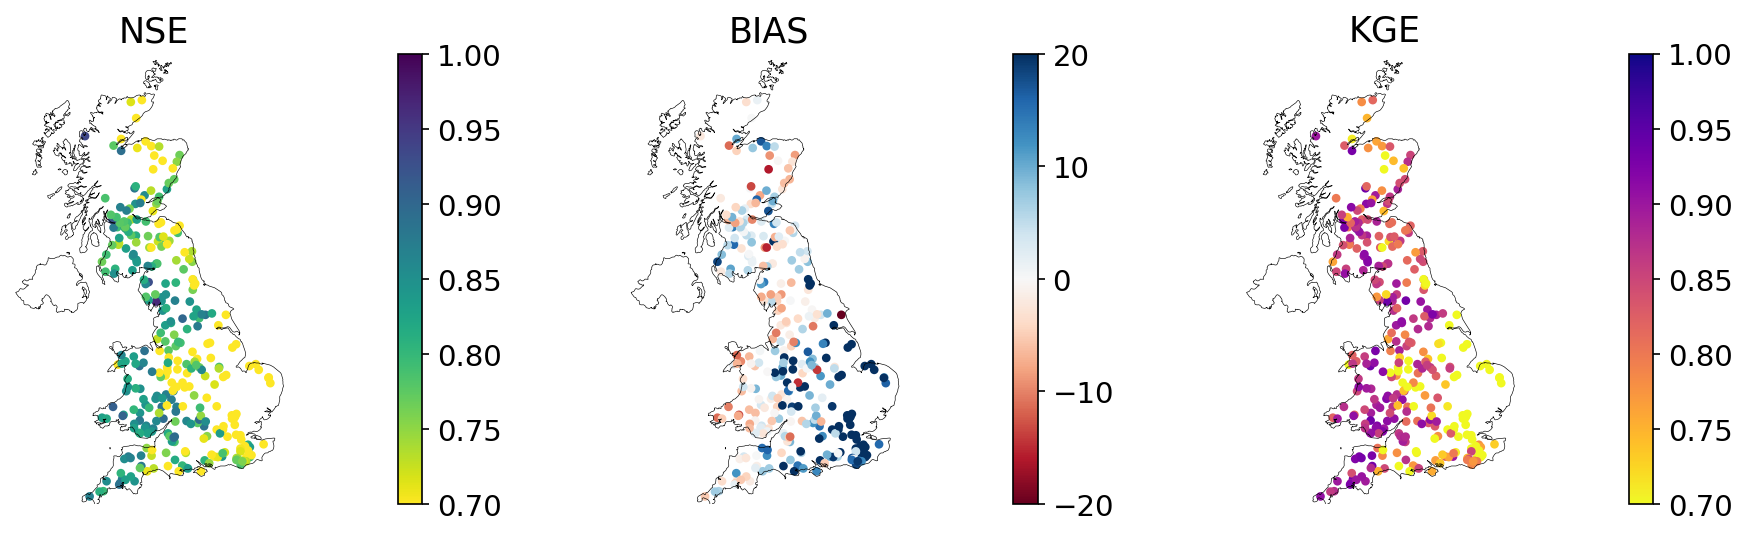

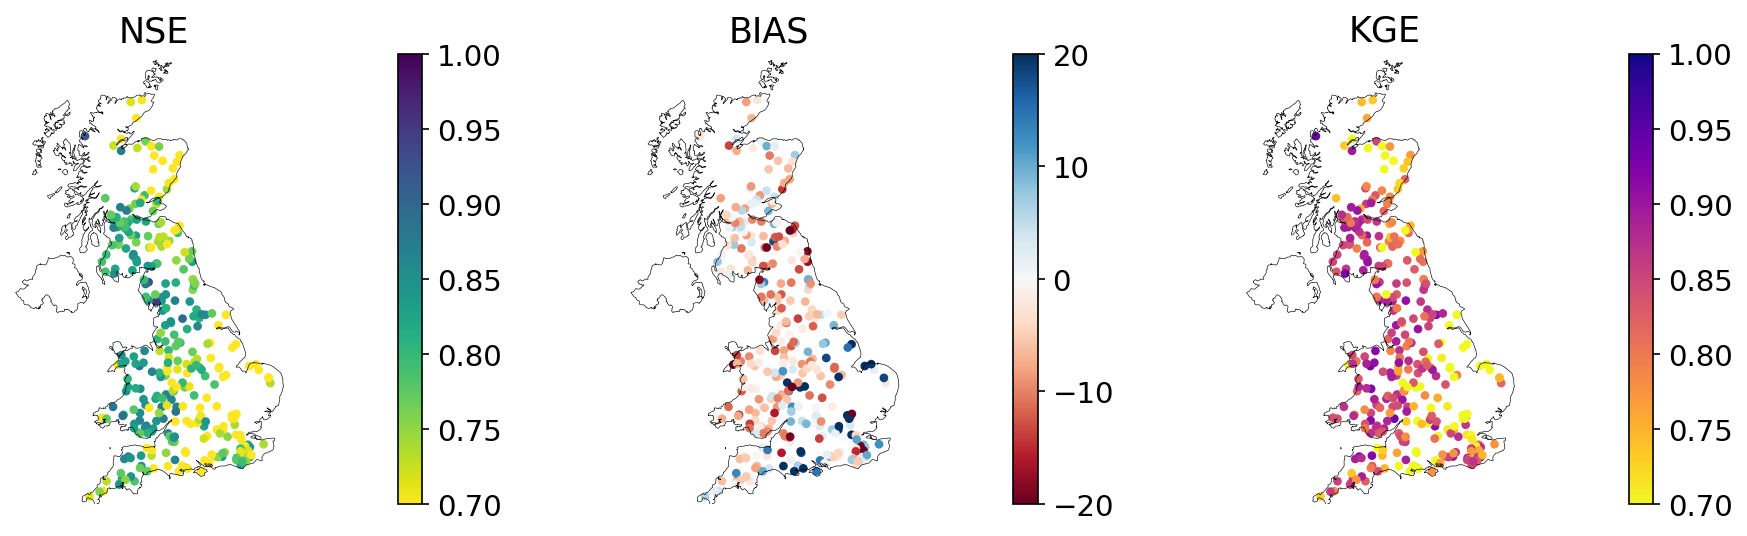

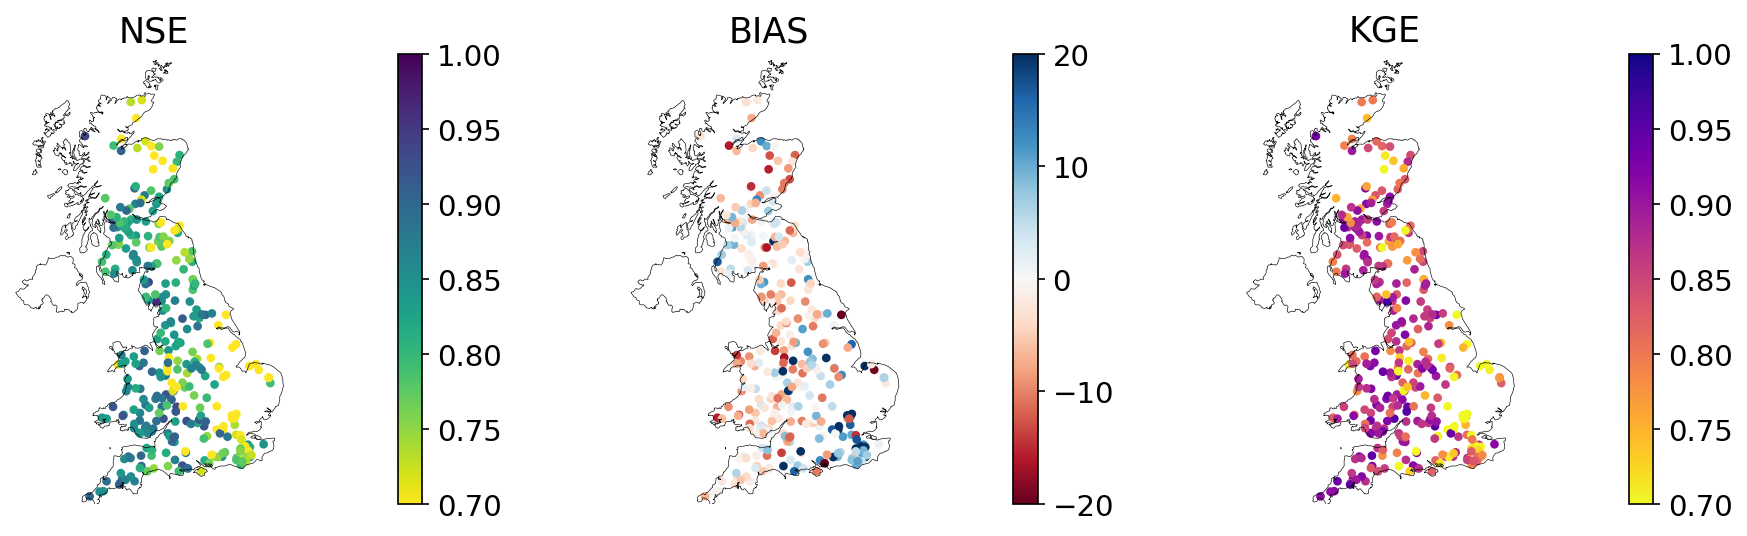

In [145]:
plot_geospatial_data(vic_gdf, model="VIC")
plot_geospatial_data(prms_gdf, model="PRMS")
plot_geospatial_data(top_gdf, model="TOPMODEL")
plot_geospatial_data(sac_gdf, model="Sacramento")

# Look at performance at either end of the extremes

## Calculate the Q5 / Q95 metrics

In [146]:
# all_preds 
from scripts.drafts.calculate_error_scores import DeltaError

# calculate all error metrics
processor = DeltaError(ealstm_preds, lstm_preds, fuse_data)
all_preds = processor.all_preds

In [147]:
# less than or equal Q5
q5_flows = all_preds.where(all_preds["obs"] <= all_preds["obs"].quantile(q=0.05, dim=["time"]))
# more than or equal Q95
q95_flows = all_preds.where(all_preds["obs"] >= all_preds["obs"].quantile(q=0.95, dim=["time"]))

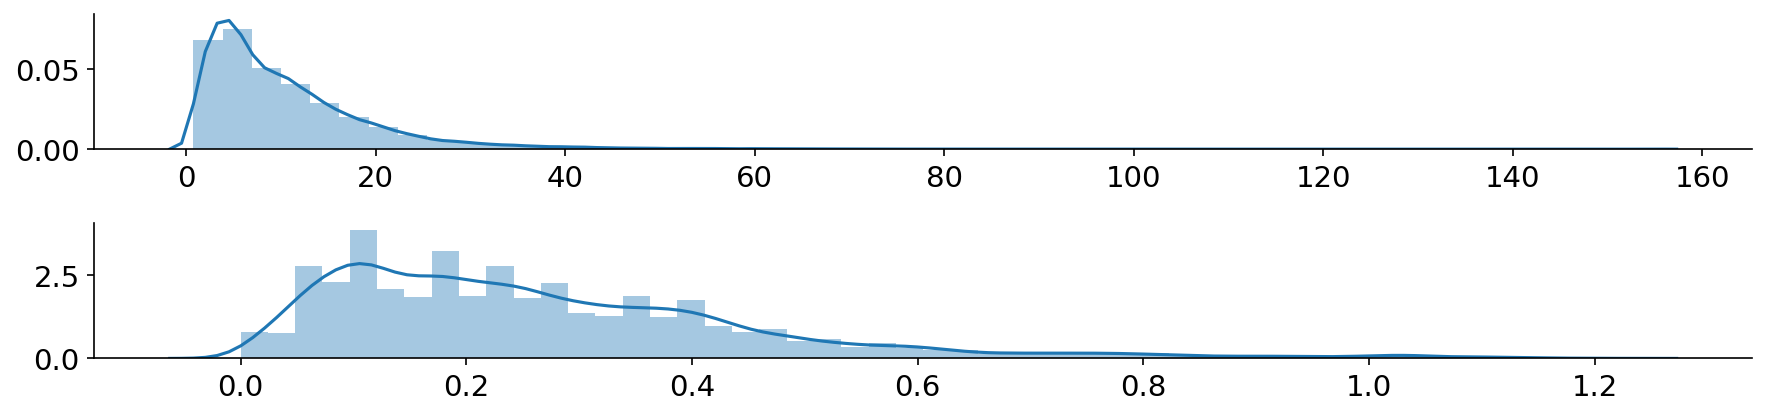

In [148]:
f, axs = plt.subplots(2, 1, figsize=(12, 3))
ax = axs[0]
sns.distplot(q95_flows["obs"].values[~np.isnan(q95_flows["obs"].values)], ax=ax)
ax = axs[1]
sns.distplot(q5_flows["obs"].values[~np.isnan(q5_flows["obs"].values)], ax=ax)
plt.tight_layout()
sns.despine()

In [149]:
def calculate_all_errors_xr(all_simulations: xr.Dataset) -> xr.Dataset:
    assert all(np.isin(["obs"], all_simulations.data_vars))

    all_errors: List[xr.Dataset] = []
    for ix, model in enumerate(tqdm([v for v in all_simulations.data_vars if v != "obs"], desc="Calculating Errors")):
        preds = all_simulations[[model, "obs"]].rename({model: "sim"})
        errors_df = calculate_errors(preds)
        errors_df["model"] = [model for _ in range(len(errors_df))]
        error_xr = errors_df.set_index(["station_id", "model"]).to_xarray()
        all_errors.append(error_xr)
    all_errors = xr.combine_by_coords(all_errors)
    return all_errors

In [150]:
q5_errors = calculate_all_errors_xr(q5_flows)

Calculating Errors: 100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


In [151]:
q95_errors = calculate_all_errors_xr(q95_flows)

Calculating Errors: 100%|██████████| 6/6 [00:12<00:00,  2.17s/it]


In [152]:
q95_errors["rmse"] = np.sqrt(q95_errors["mse"])
q5_errors["rmse"] = np.sqrt(q5_errors["mse"])

In [153]:
all_q95_errors = q95_errors.to_dataframe().reset_index().set_index("station_id")
# all_q95_errors["rmse"] = np.sqrt(all_q95_errors["mse"])
all_q5_errors = q5_errors.to_dataframe().reset_index().set_index("station_id")
# all_q5_errors["rmse"] = np.sqrt(all_q5_errors["mse"])

In [154]:
# import missingno as msno
# msno.bar(q5_flows.to_dataframe().reset_index("station_id"))
# msno.bar(q95_flows.to_dataframe().reset_index("station_id"))

In [155]:
def get_metric_from_xarray_error(xr_errors: xr.Dataset, metric: str = "nse") -> pd.DataFrame:
    # convert to dataframe
    _errors = xr_errors.to_dataframe().reset_index().set_index("station_id")
    # extract the model
    df_errors = (
        _errors
        .loc[:, ["model", metric]]
        .reset_index()
        .set_index(["station_id", "model"])
        .unstack().droplevel(axis=1, level=0)
    )
    return df_errors
    
# q95_nse_df = all_q95_errors.loc[:, ["model", "nse"]].reset_index().set_index(["station_id", "model"]).unstack().droplevel(axis=1, level=0)
q95_nse_df = get_metric_from_xarray_error(q95_errors, metric="nse")
q5_rmse_df = get_metric_from_xarray_error(q5_errors, metric="rmse")
q95_rmse_df = get_metric_from_xarray_error(q95_errors, metric="rmse")
q5_bias_df = get_metric_from_xarray_error(q5_errors, metric="bias")
q95_bias_df = get_metric_from_xarray_error(q95_errors, metric="bias")
q95_nse_df.head()

model,ARNOVIC,EALSTM,LSTM,PRMS,SACRAMENTO,TOPMODEL
station_id,,,,,,
2001,-0.826467,-0.460285,-0.503745,-0.758664,-0.768743,-0.677931
4001,-0.105598,0.230630,0.340873,-0.649686,-0.192711,-0.831285
4003,-0.468172,-0.039927,0.017034,-0.671839,-0.410567,-0.743213
6007,0.554954,0.429172,0.461628,0.446600,0.510352,0.484546
7003,0.621566,0.674163,0.671391,0.658886,0.702492,0.700044


In [156]:
from typing import Optional, List, Tuple

def plot_cdf(error_data, metric: str, sids: List[int] = ml_sids, clip: Optional[Tuple] = None, ax = None):
    colors = sns.color_palette()
    kwargs_dict = {
        "TOPMODEL": {"linewidth": 1, "alpha":0.8, "color": colors[2], "clip": clip},
        "PRMS": {"linewidth": 1, "alpha":0.8, "color": colors[3], "clip": clip},
        "ARNOVIC": {"linewidth": 1, "alpha":0.8, "color": colors[4], "clip": clip},
        "VIC": {"linewidth": 1, "alpha":0.8, "color": colors[4], "clip": clip},
        "SACRAMENTO": {"linewidth": 1, "alpha":0.8, "color": colors[5], "clip": clip},
        "EALSTM": {"linewidth": 3, "alpha": 1, "color": colors[1], "clip": clip},
        "LSTM": {"linewidth": 3, "alpha": 1, "color": colors[0], "clip": clip},
    }
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))

    for ix, model in enumerate(error_data.columns):
        sns.kdeplot(
            error_data[model].dropna(),
            cumulative=True,
            legend=False, ax=ax,
            label=f"{model}: {error_data[model].median():.2f}",
            **kwargs_dict[model]
        )

        ax.axvline(error_data[model].dropna().median(), ls="--", color=kwargs_dict[model]["color"])

    ax.set_xlim(clip)
    ax.set_xlabel(metric)
    ax.set_ylabel("Cumulative density")
    title = f"Cumuluative Density Function of Station {metric} Scores"
    ax.set_title(title)
    sns.despine()
    plt.legend()
    
    return ax

# ax = plot_cdf(q95_rmse_df, metric="RMSE", sids=ml_sids, clip=None)

In [157]:
# clip = (-1, 1)
# fig, ax = plt.subplots(figsize=(12, 8))
# plot_cdf(q95_nse_df, metric="NSE", sids=ml_sids, clip=clip, ax=ax)
# ax.set_title("CDF of Q95 NSE")

Text(0.5, 1.0, 'CDF of Q5 RMSE')

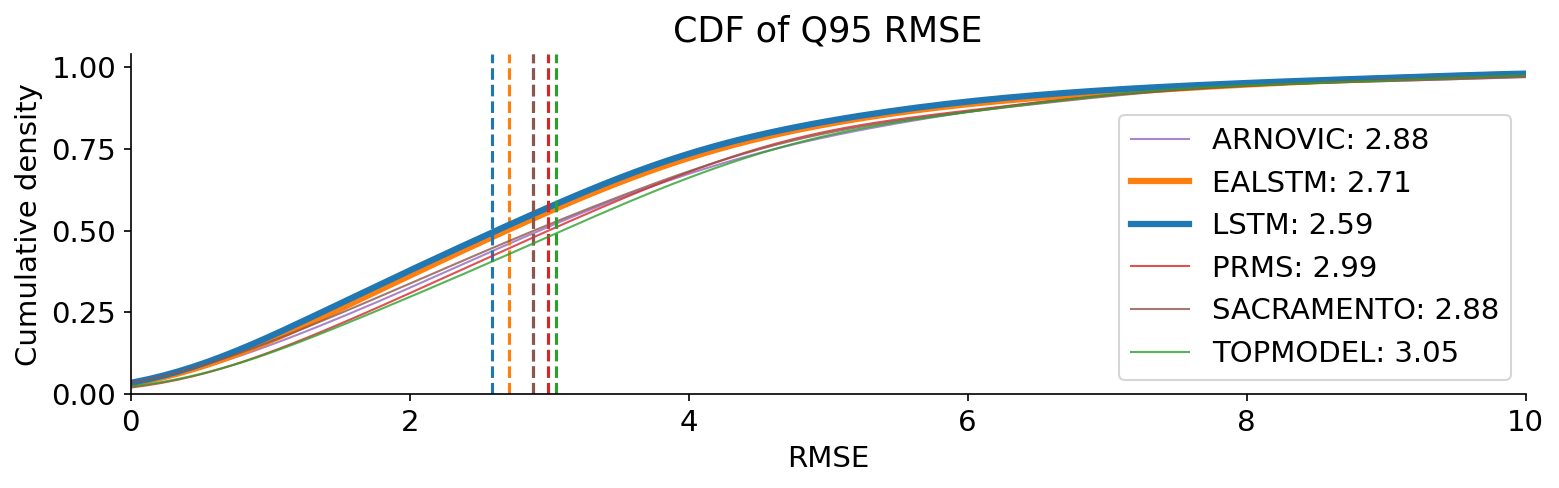

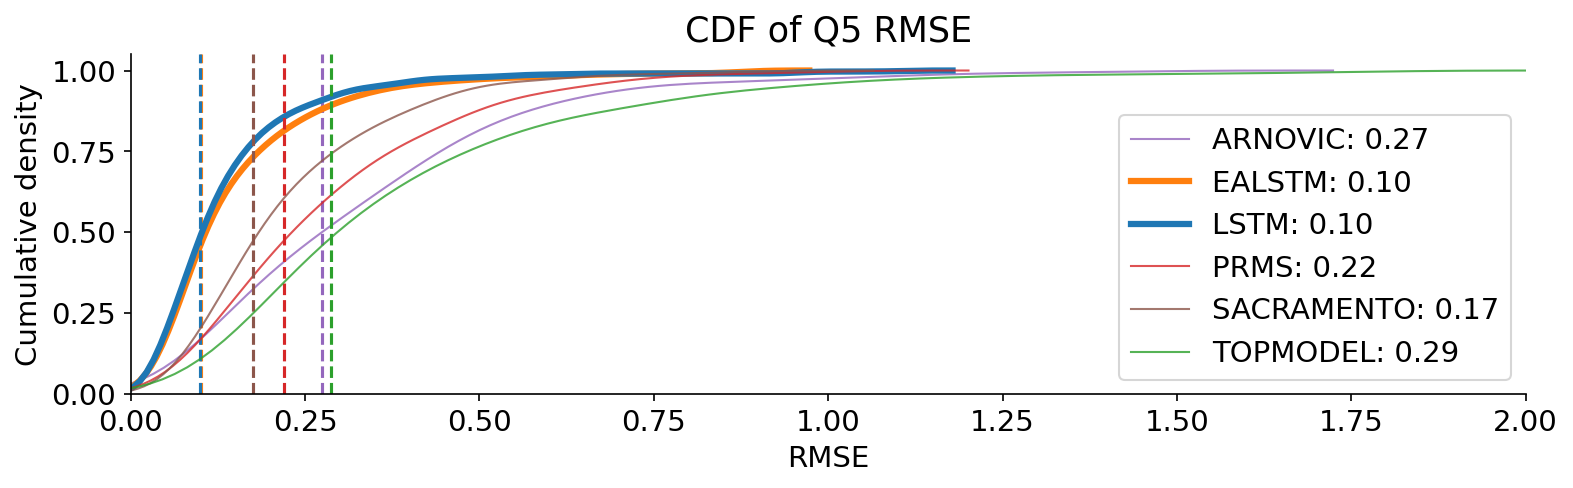

In [158]:
ax = plot_cdf(q95_rmse_df, metric="RMSE", sids=ml_sids, clip=(0, 10))
ax.set_title("CDF of Q95 RMSE")

# fig, ax = plt.subplots(figsize=(12, 8))
ax = plot_cdf(q5_rmse_df, metric="RMSE", sids=ml_sids, clip=(0, 2), ax=None)
ax.set_title("CDF of Q5 RMSE")

In [159]:
pubs = (
    pub_nse.set_index("station_id")
    .rename({"NSE_TOPMODEL": "TOPMODEL", "NSE_PRMS": "PRMS", "NSE_VIC": "VIC", "NSE_SACRAMENTO": "SACRAMENTO"}, axis=1)
    .loc[:, ["TOPMODEL", "PRMS", "VIC", "SACRAMENTO"]]
)
all_pubs = pubs.join(lstm_df["nse"].rename("LSTM")).join(ealstm_df["nse"].rename("EALSTM")).dropna()

Text(0.5, 1.0, 'CDF of Published NSE Scores')

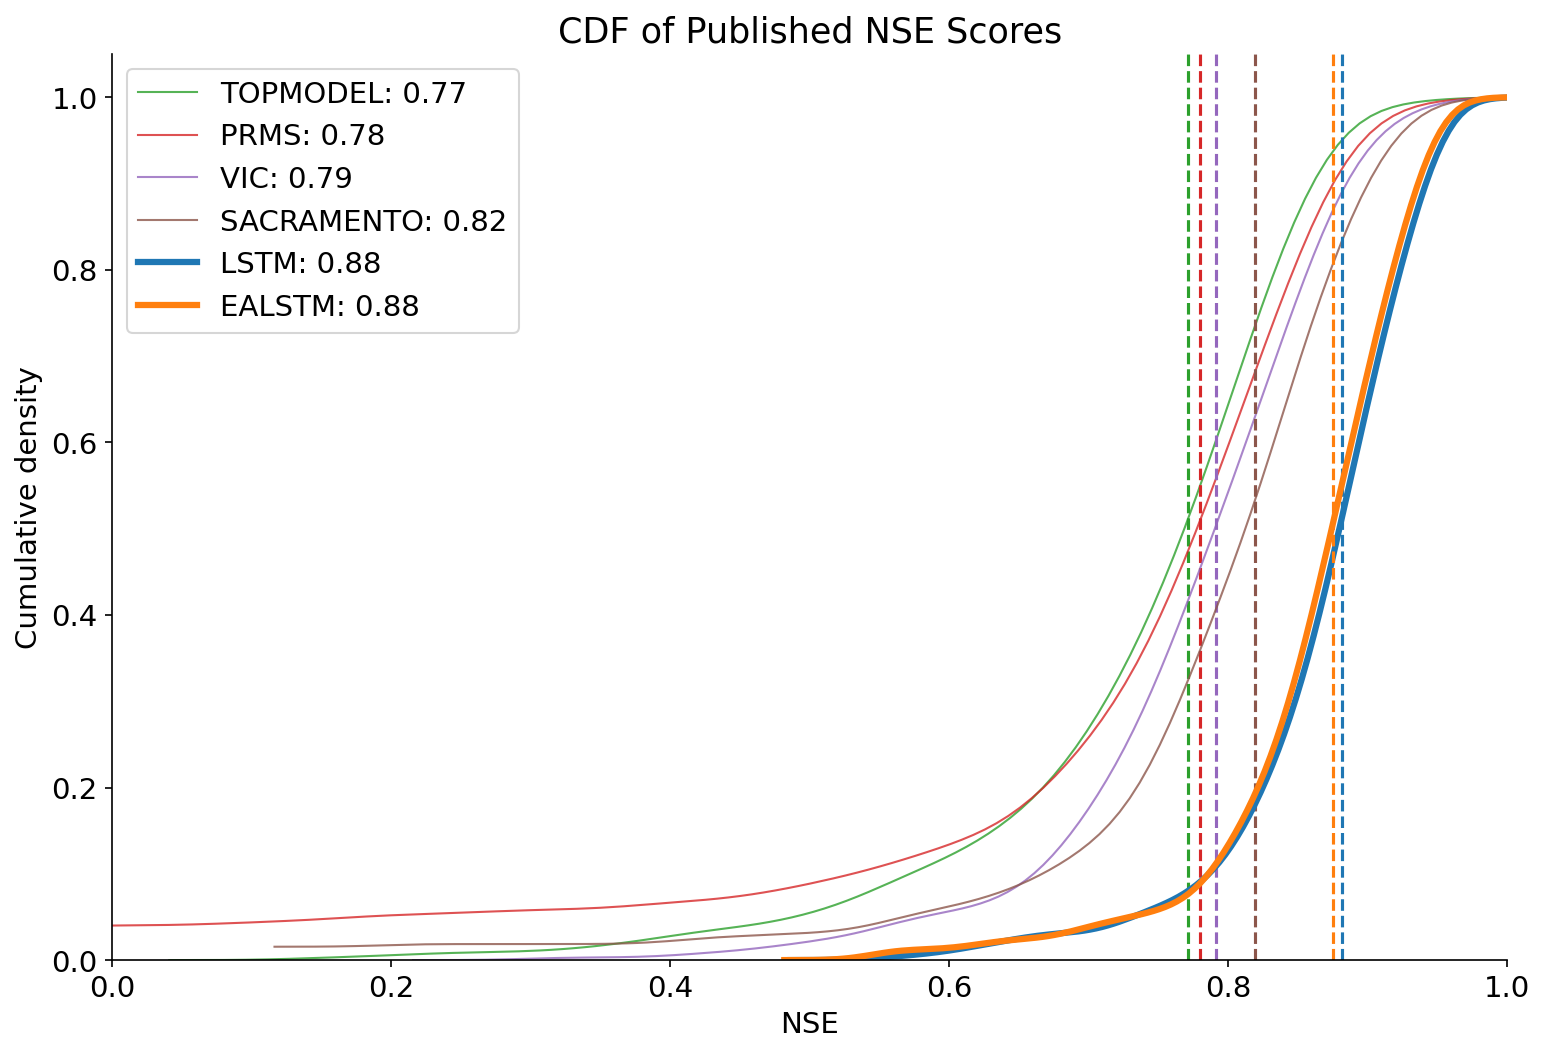

In [160]:
f, ax = plt.subplots(figsize=(12, 8))
ax = plot_cdf(all_pubs, metric="NSE", sids=ml_sids, clip=(0, 1), ax=ax)
ax.set_title("CDF of Published NSE Scores")

In [161]:
lstm_data


station_id
2001      0.728138
4001      0.860072
4003      0.782560
6007      0.849447
7003      0.807583
            ...   
89003     0.717024
94001     0.941273
96001     0.770542
97002     0.795177
101002    0.694666
Name: kge, Length: 323, dtype: float64

In [162]:
# # for model in models + ["LSTM"]:
# #     sns.distplot(all_q95_errcolors = sns.color_palette()

# clip = (0, 2)
# lstm_data = q5_rmse_df.loc[ml_sids, 'LSTM']
# ealstm_data = q5_rmse_df.loc[ml_sids, 'EALSTM']
# concept_data = q5_rmse_df.loc[ml_sids,]

# fig, ax = plt.subplots(figsize=(12, 3))
# sns.kdeplot(
#     lstm_data,
#     cumulative=True,
#     legend=False, ax=ax,
#     clip=clip,
#     label=f"LSTM: {lstm_data.median():.2f}",
#     **{"ls": "-"},
#     linewidth=3,
# )

# sns.kdeplot(
#     ealstm_data,
#     cumulative=True,
#     legend=False, ax=ax,
#     clip=clip,
#     label=f"EALSTM: {ealstm_data.median():.2f}",
#     linewidth=3,
# )

# for conceptual_ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
#     sns.kdeplot(
#         concept_data[model].dropna(),
#         cumulative=True,
#         legend=False, ax=ax,
#         clip=clip,
#         label=f"{model}: {concept_data[model].median():.2f}",
#         color=colors[conceptual_ix+2], alpha=0.8, linewidth=1
#     )
#     plt.legend()
#     ax.axvline(concept_data[model].dropna().median(), ls="--", color=colors[conceptual_ix+2], alpha=0.8, linewidth=1)  # color=colors[conceptual_ix+1]


# ax.axvline(lstm_data.median(), ls="--", color=colors[0])
# ax.axvline(ealstm_data.median(), ls="--", color=colors[1])

# ax.set_xlim(clip)
# ax.set_xlabel("RMSE")
# ax.set_ylabel("Cumulative density")
# title = f"Cumuluative Density Function of Station RMSE Scores for Q95 Flows"
# ax.set_title(title)
# sns.despine()

##  What about log nse and 1/KGE?

In [163]:
display(lstm_df.head())
create_joined_metric_df("log_nse")
create_joined_metric_df("inv_kge")

,nse,kge,mse,bias,log_nse,inv_kge,rmse
station_id,,,,,,,
2001,0.773687,0.728138,1.438293,-13.445427,0.870523,0.728138,1.199288
4001,0.866291,0.860072,1.879023,-1.970809,0.797380,0.860072,1.370775
4003,0.826035,0.782560,2.114588,-7.473661,0.881892,0.782560,1.454162
6007,0.914473,0.849447,1.232530,-5.592752,0.843899,0.849447,1.110194
7003,0.843774,0.807583,0.441996,-5.575149,0.907332,0.807583,0.664828


,Name,LSTM,EALSTM
2001,Helmsdale at Kilphedir,0.728138,0.733008
4001,Conon at Moy Bridge,0.860072,0.842440
4003,Alness at Alness,0.782560,0.776367
6007,Ness at Ness-side,0.849447,0.842110
7003,Lossie at Sheriffmills,0.807583,0.813415
...,...,...,...
89003,Orchy at Glen Orchy,0.717024,0.731646
94001,Ewe at Poolewe,0.941273,0.965938
96001,Halladale at Halladale,0.770542,0.737792
97002,Thurso at Halkirk,0.795177,0.821011


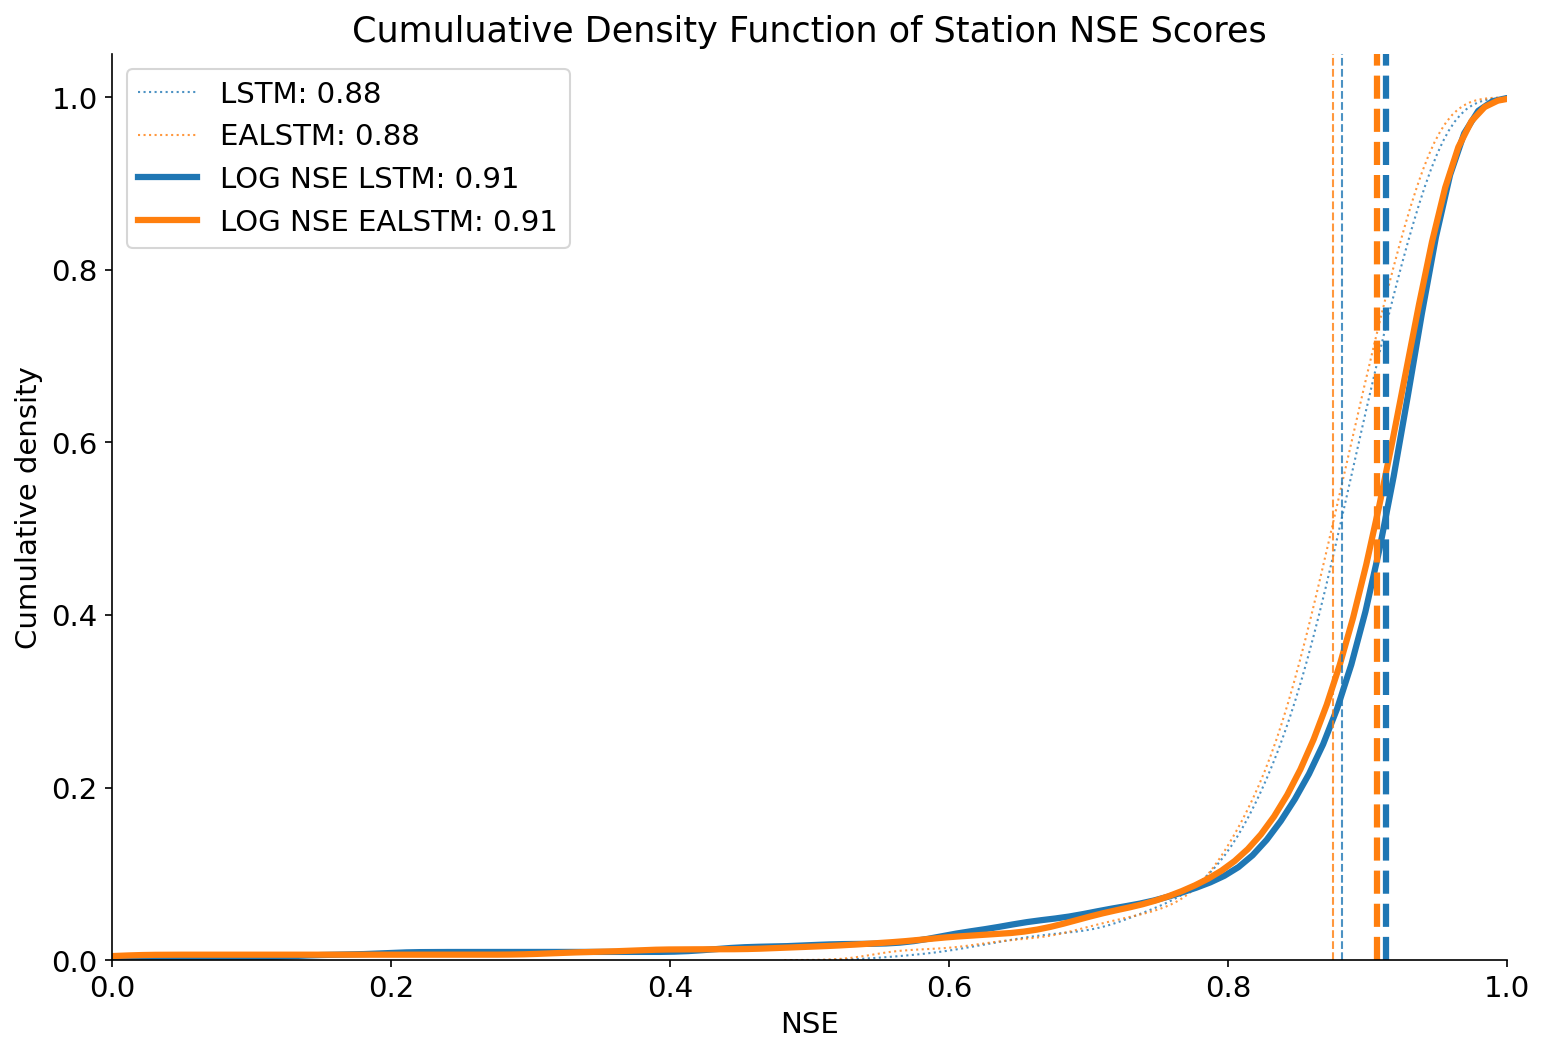

In [164]:
colors = sns.color_palette()

lstm_data_nse = lstm_df.loc[:, 'nse']
lstm_data_log = lstm_df.loc[:, 'log_nse']
ealstm_data_nse = ealstm_df.loc[:, 'nse']
ealstm_data_log = ealstm_df.loc[:, 'log_nse']

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    lstm_data_nse,
    cumulative=True,
    legend=False, ax=ax,
    clip=[-0.5, 1],
    label=f"LSTM: {lstm_data_nse.median():.02f}",
    **{"ls": ":"},
    linewidth=1,
    color=sns.color_palette()[0],
    alpha=0.8
)

sns.kdeplot(
    ealstm_data_nse,
    cumulative=True,
    legend=False, ax=ax,
    clip=[-0.5, 1],
    label=f"EALSTM: {ealstm_data_nse.median():.02f}",
    linewidth=1,
    **{"ls": ":"},
    color=sns.color_palette()[1],
    alpha=0.8
)

sns.kdeplot(
    lstm_data_log,
    cumulative=True,
    legend=False, ax=ax,
    clip=[-0.5, 1],
    label=f"LOG NSE LSTM: {lstm_data_log.median():.02f}",
    linewidth=3,
    color=sns.color_palette()[0],
)

sns.kdeplot(
    ealstm_data_log,
    cumulative=True,
    legend=False, ax=ax,
    clip=[-0.5, 1],
    label=f"LOG NSE EALSTM: {ealstm_data_log.median():.02f}",
    linewidth=3,
    color=sns.color_palette()[1],
)


ax.axvline(lstm_data_nse.median(), ls="--", color=colors[0], alpha=0.8, linewidth=1)
ax.axvline(lstm_data_log.median(), ls="--", color=colors[0], alpha=1, linewidth=3)
ax.axvline(ealstm_data_nse.median(), ls="--", color=colors[1], alpha=0.8, linewidth=1)
ax.axvline(ealstm_data_log.median(), ls="--", color=colors[1], alpha=1, linewidth=3)

ax.set_xlim([-0, 1])
ax.set_xlabel("NSE")
ax.set_ylabel("Cumulative density")
title = f"Cumuluative Density Function of Station NSE Scores"
ax.set_title(title)
ax.legend()
sns.despine()

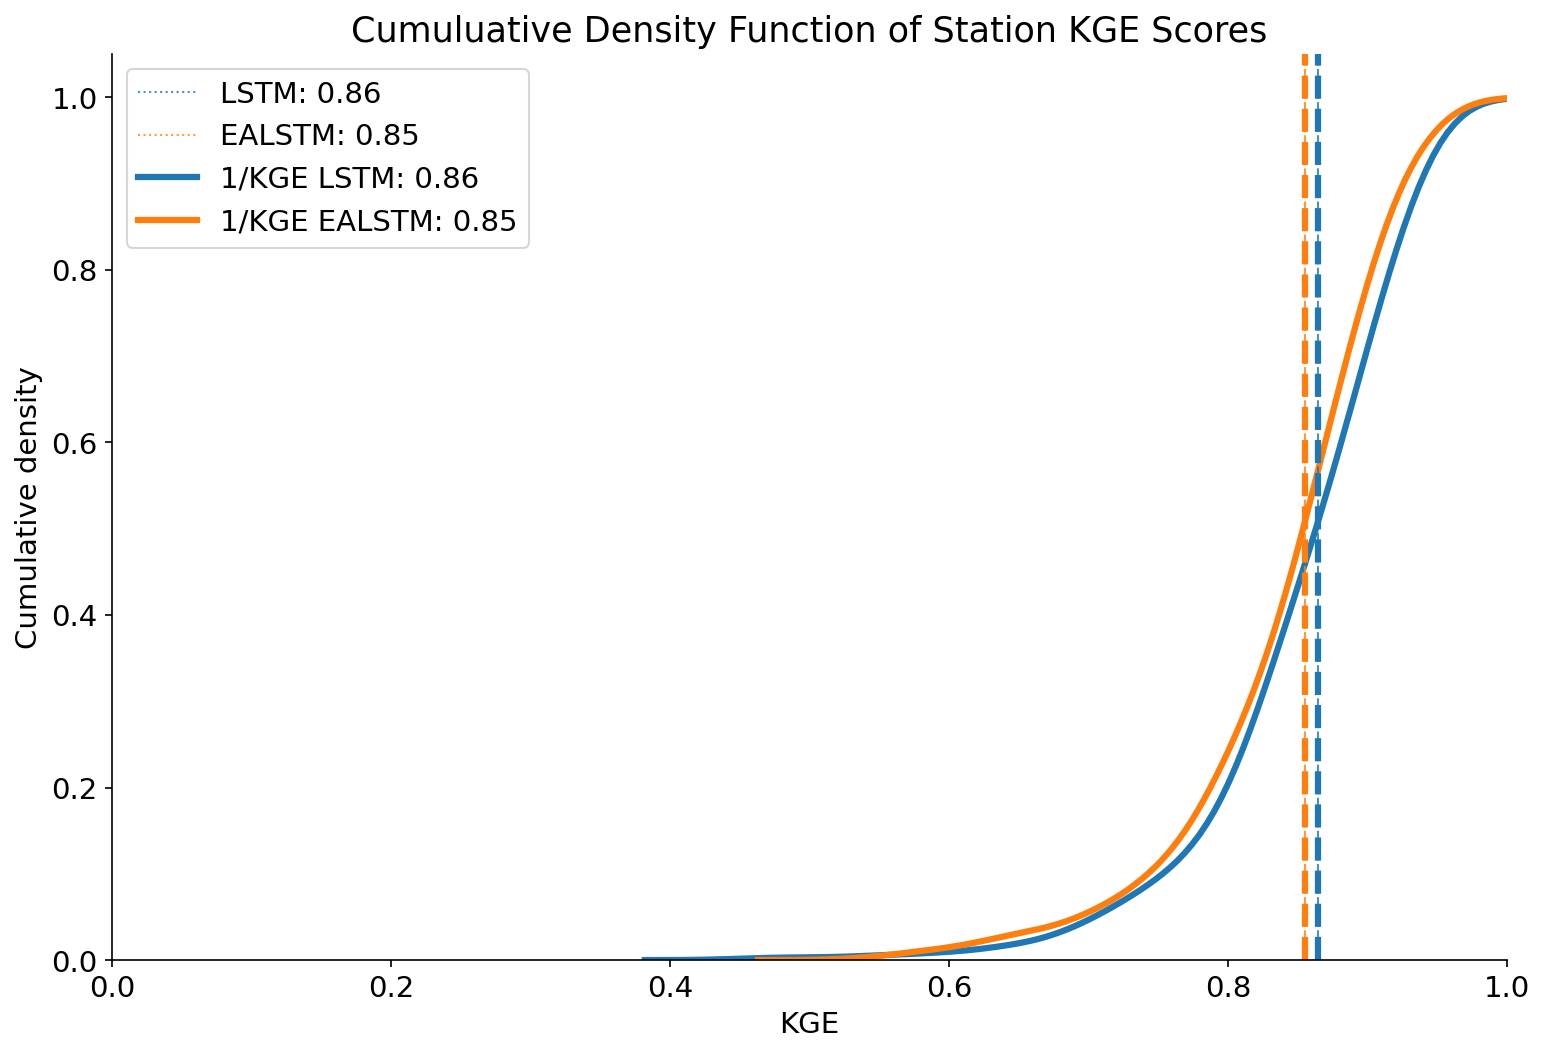

In [165]:
colors = sns.color_palette()

lstm_data_kge = lstm_df.loc[:, 'kge']
lstm_data_inv = lstm_df.loc[:, 'inv_kge']
ealstm_data_kge = ealstm_df.loc[:, 'kge']
ealstm_data_inv = ealstm_df.loc[:, 'inv_kge']

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    lstm_data_kge,
    cumulative=True,
    legend=False, ax=ax,
    clip=[-0.5, 1],
    label=f"LSTM: {lstm_data_kge.median():.02f}",
    **{"ls": ":"},
    linewidth=1,
    color=sns.color_palette()[0],
    alpha=0.8
)

sns.kdeplot(
    ealstm_data_kge,
    cumulative=True,
    legend=False, ax=ax,
    clip=[-0.5, 1],
    label=f"EALSTM: {ealstm_data_kge.median():.02f}",
    linewidth=1,
    **{"ls": ":"},
    color=sns.color_palette()[1],
    alpha=0.8
)

sns.kdeplot(
    lstm_data_inv,
    cumulative=True,
    legend=False, ax=ax,
    clip=[-0.5, 1],
    label=f"1/KGE LSTM: {lstm_data_inv.median():.02f}",
    linewidth=3,
    color=sns.color_palette()[0],
)

sns.kdeplot(
    ealstm_data_inv,
    cumulative=True,
    legend=False, ax=ax,
    clip=[-0.5, 1],
    label=f"1/KGE EALSTM: {ealstm_data_inv.median():.02f}",
    linewidth=3,
    color=sns.color_palette()[1],
)


ax.axvline(lstm_data_kge.median(), ls="--", color=colors[0], alpha=0.8, linewidth=1)
ax.axvline(lstm_data_inv.median(), ls="--", color=colors[0], alpha=1, linewidth=3)
ax.axvline(ealstm_data_kge.median(), ls="--", color=colors[1], alpha=0.8, linewidth=1)
ax.axvline(ealstm_data_inv.median(), ls="--", color=colors[1], alpha=1, linewidth=3)

ax.set_xlim([-0, 1])
ax.set_xlabel("KGE")
ax.set_ylabel("Cumulative density")
title = f"Cumuluative Density Function of Station KGE Scores"
ax.set_title(title)
ax.legend()
sns.despine()

# Explore Spatial Patterns
- https://widdowquinn.github.io/Teaching-Data-Visualisation/exercises/interactive_bokeh_map/interactive_bokeh_map.html
- Plot interctive map with Bokeh
- https://automating-gis-processes.github.io/2016/Lesson5-interactive-map-bokeh.html

In [166]:
from scripts.drafts.calculate_error_scores import DeltaError

# calculate all error metrics
processor = DeltaError(ealstm_preds, lstm_preds, fuse_data)
all_preds = processor.all_preds

In [167]:
from typing import Optional
import matplotlib.dates as mdates

static_df = static.to_dataframe()

def plot_station_hydrograph(data: pd.DataFrame, station_id: int, plot_conceptual: bool = True, ax: Optional = None):
    assert all(np.isin(["time", "LSTM", "EALSTM", "obs"], data.columns))
    station_name = static_df.loc[station_id, "gauge_name"]
    data = data.loc[station_id]
    
    if ax is None:
        f, ax = plt.subplots(figsize=(12, 4))
    else:
        f = plt.gcf()
        
    ax.plot(data["time"], data["LSTM"], color=sns.color_palette()[0], label="LSTM", alpha=1, linewidth=2)
    ax.plot(data["time"], data["EALSTM"], color=sns.color_palette()[1], label="EA LSTM", alpha=1, linewidth=2)
    if plot_conceptual:
        ax.plot(data["time"], data["TOPMODEL"], label="TOPMODEL", alpha=0.5, linewidth=1, color=sns.color_palette()[2])
        ax.plot(data["time"], data["ARNOVIC"], label="VIC", alpha=0.5, linewidth=1, color=sns.color_palette()[3])
        ax.plot(data["time"], data["PRMS"], label="PRMS", alpha=0.5, linewidth=1, color=sns.color_palette()[4])
        ax.plot(data["time"], data["SACRAMENTO"], label="Sacramento", alpha=0.5, linewidth=1, color=sns.color_palette()[5])

    ax.plot(data["time"], data["obs"], color="k", ls=":", label="Observed")
    ax.legend()

    ax.set_title(f"Station: {station_name} - {station_id}")  # \nNSE: {} -- Bias: {} -- {}
    ax.set_xlabel("Time")
    ax.set_ylabel("Specific Discharge")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    sns.despine()
    
    return f, ax

In [168]:
# lstm_gdf.plot("ID", legend=True, scheme='quantiles');

In [169]:
lstm_gdf.index

Int64Index([ 10002,  10003,   1001, 101002, 101005, 102001, 106001, 107001,
             11001,  11003,
            ...
              9004,   9005,  92001,  93001,  94001,  95001,  96001,  96002,
             96004,  97002],
           dtype='int64', name='ID_STRING', length=671)

In [170]:
se_ids = lstm_gdf.ID[(lstm_gdf.ID > 37010) & (lstm_gdf.ID < 45001)]
all_df = all_preds.to_dataframe().reset_index().set_index("station_id")

KeyError: 39011

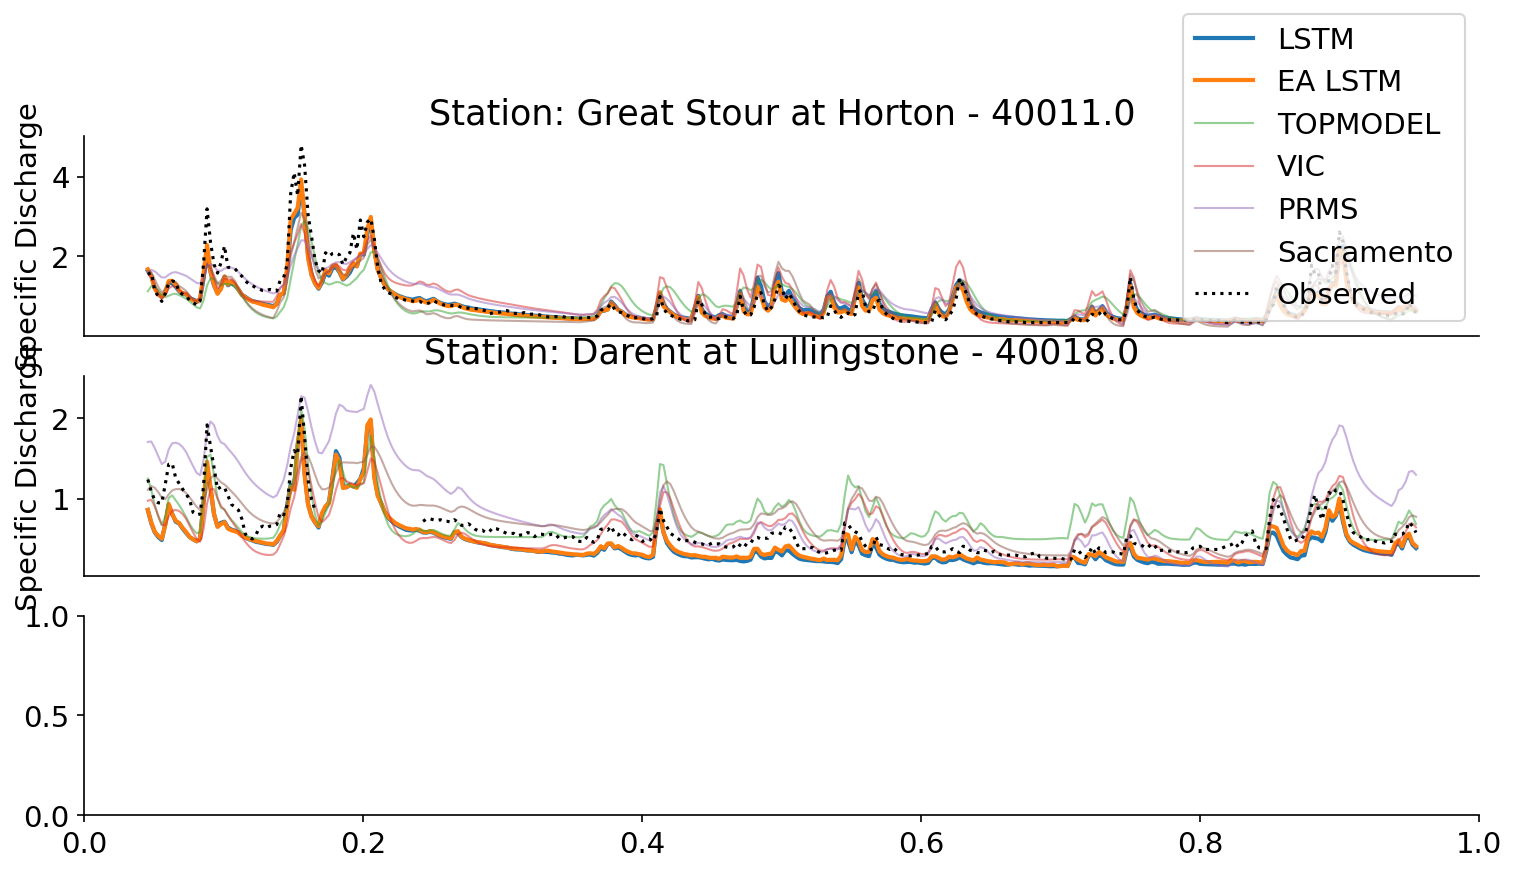

In [171]:
# 39035 - Churn at Cerney Wick
# 41004 - Ouse at Barcombe Mills
# 39004 - Wandle @ Beddington Park
# 39049 - Silk Stream (pretty good for all)
N_STATIONS = 3
sids = np.random.choice(se_ids, N_STATIONS)

f, axs = plt.subplots(N_STATIONS, 1, figsize=(12, 2*N_STATIONS))
for ix, sid in enumerate(sids):
    ax = axs[ix]
    plot_station_hydrograph(all_df.loc[all_df.time.dt.year == 2007], sid, ax=ax);
    if ix != 0:
        ax.get_legend().remove()
    if ix != N_STATIONS - 1:
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_xlabel("")

    
plt.tight_layout()

In [ ]:
sids

In [ ]:
[c for c in static_df["gauge_name"] if "Churn" in c]
static_df.loc[static_df["gauge_name"] == "Churn at Cerney Wick"]

# SM data

In [ ]:
def read_gb_sm_data() -> xr.Dataset:
    if not (data_dir / "RUNOFF/gb_sm_catchments_1993_2020.nc").exists():
        all_sm_ds = []
        for ix, path in enumerate(tqdm(list((data_dir / "RUNOFF/sm_data").glob("*Level*.csv")), desc="Reading SM Level")):
            # read in data
            df = (
                pd.read_table(d, sep=";", decimal=",")
                .drop("Unnamed: 0", axis=1)
                .rename({"Date": "time"}, axis=1)
                .astype({"time": "datetime64[ns]"})
            )
            # create index from station, time, rename column to soil level volume
            df = (
                df.melt(id_vars='time')
                .astype({"value": "float64", "variable": "int64"})
                .rename(
                    {
                        "value": f'swvl{path.name.split("Level_")[-1].replace(".csv", "")}',
                        "variable": "station_id"
                    }
                , axis=1)
                .set_index(["time", "station_id"])
            )    

            # convert to xarray
            ds = df.to_xarray()
            all_sm_ds.append(ds)

        ds = xr.combine_by_coords(all_sm_ds)
        ds.to_netcdf(data_dir / "RUNOFF/gb_sm_catchments_1993_2020.nc")


    else: 
        ds = xr.open_dataset(data_dir / "RUNOFF/gb_sm_catchments_1993_2020.nc")

In [ ]:
# d = [d for (ix, d) in enumerate((data_dir / "RUNOFF/sm_data").glob("*Level*.csv"))][0]

# [
#     df.to_xarray()
#     for (ix, df) in enumerate(sm_csvs)
# ]
# df = sm_csvs[0]
# df.head()

In [ ]:
df.reset_index()